# Install Package

In [ ]:
!pip install spams
!pip install staintools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 34.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp38-cp38-linux_x86_64.whl size=3241014 sha256=d61e612fb4c81dad9e9fd1a54b94ee11a98cf2c205814889066b9a495d1506a3
  Stored in directory: /root/.cache/pip/wheels/38/d6/cd/b79299cdb26aa57760dbbeb096bc8b71b10c69f4bb95dbd16c
Successfully built spams
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14072 sha256=f80210211c48cbcccfa746fc1789f89dfc09fb954706a7ca5030e8e020a83bb0
  Stored in directory: /root/.cache/pip/wheels/09/ed/d3/94d11aa73ab04cc3a727faa6ee8618ff540877cb98a7abb14e
Successfully built staintools


# Import Libraries

In [ ]:
import itertools
import os
import statistics
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import PIL
from google.colab import drive
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle 
import sklearn
import sklearn.model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from keras import backend as K
from sklearn.utils import class_weight 
import pathlib
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc,  roc_curve, balanced_accuracy_score, cohen_kappa_score
from scipy import interp
import time
import sys
import staintools
import cv2 as cv

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
Hub version: 0.12.0
GPU is available


# Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Initialise Functions

In [ ]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))



def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


def create_model(model, class_weights):

  model_handle_map = {
  "EB0V2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "EB0V2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "EB0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "RV1": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
  "RV2": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
  "MB1": "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5",
  "MB2": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
  }
  
  model_handle = model_handle_map.get(model)
  print(f"Selected model: {model} : {model_handle}")
  print("Building model with", model_handle)
  do_fine_tuning = False

  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),                                       
  ])


  base_model = hub.KerasLayer(model_handle, trainable=do_fine_tuning)
  dense_layer = tf.keras.layers.Dense(256, activation='relu')
  prediction_layer = tf.keras.layers.Dense(4, activation='softmax')

  inputs = tf.keras.Input(shape=IMAGE_SIZE+(3,))
  x = data_augmentation(inputs)
  x = base_model(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = dense_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x) 
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs, name = model)

  weights = np.fromiter(class_weights.values(), dtype=float)
  print('Class weights:',weights)
  loss = weighted_categorical_crossentropy(weights)

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
  loss=loss,
  metrics=['accuracy'])

  model.summary()
  
  return model




def plot_confusion_matrix(cm, classes, dir,
                          normalize=False,
                          title='Confusion matrix',
                          
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(dir)
    plt.close()



# Temp 1

# Setup SN Dataset

In [ ]:
# Reinhard
sn_label = 'V'
temp_img = 'Temp1'

# original dataset
base_path = "/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset"

# temp image path
temp_img_path = f"/content/drive/Shareddrives/Unlimited Drive/SN/Template/{temp_img}.png"

#  make a temp directory to save SN dataset
save_path = f'/content/{sn_label}_{temp_img}'
if not os.path.exists(save_path):
  os.mkdir(save_path)

# Setup Model

In [ ]:
# Set hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100
print('Batch size:', BATCH_SIZE, 'Epoch: ', EPOCHS)

best_weight_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Weight/{sn_label}_{temp_img}'
if not os.path.exists(best_weight_dir):
   os.mkdir(best_weight_dir)

   
figure_dir = '/content/drive/Shareddrives/Unlimited Drive/SN/Result/Figures'




metrics = {'Model Name': [], 'Balanced Accuracy': [], 'Macro Precision': [], 'Macro Recall': [], 'Macro F1score': [], 'Kappa Score': []}
result_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Result/{sn_label}_{temp_img}_result.csv'
if not os.path.exists(result_dir):
  df = pd.DataFrame(metrics) 
  df.to_csv(result_dir, index=False) 

Batch size: 16 Epoch:  100


# Form SN datasets

In [ ]:
# Define normalizer
normalizer = staintools.StainNormalizer(method="vahadane")

# Read template image
print(temp_img_path)
normalizer.fit(staintools.read_image(temp_img_path))

print(f'Folder contains {len(os.listdir(base_path))} folders')
print(os.listdir(base_path))

print('')

for type_folder in os.listdir(base_path):
  type_path = os.path.join(base_path, type_folder)
  print(f'In Folder :{type_path}')
  print('')

  for grade_folder in os.listdir(type_path):
    grade_path = os.path.join(type_path, grade_folder)
    print(f'In Folder :{grade_path}')
    print('')

    for files in os.listdir(grade_path):
      
      image_path = os.path.join(grade_path, files)
      im = normalizer.transform(staintools.read_image(image_path))


      saveim_path = os.path.join(save_path, type_folder, grade_folder)
      if not os.path.exists(saveim_path):
        os.makedirs(saveim_path)

        
      os.chdir(saveim_path) 
      file_name = str(files)
      cv.imwrite(file_name,im)

 

/content/drive/Shareddrives/Unlimited Drive/SN/Template/Temp1.png
Folder contains 2 folders
['Training Set', 'Test Set']

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_3

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_0 

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_0

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/T

# Train and Test Models

Found 711 files belonging to 4 classes.
Found 177 files belonging to 4 classes.
['Grade_0 ', 'Grade_1', 'Grade_2', 'Grade_3']
Selected model: EB0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Building model with https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                        

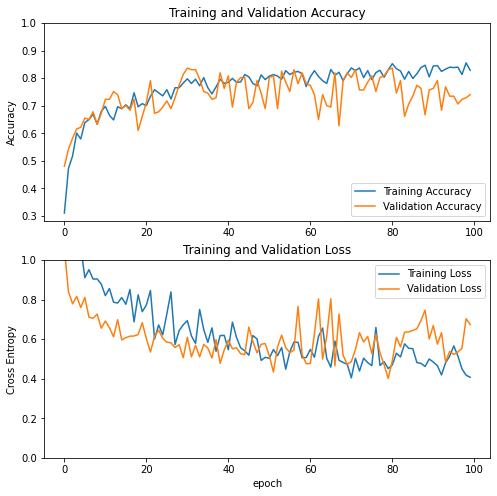

12/12 [==============================] - 0s 35ms/step - loss: 0.6096 - accuracy: 0.8362
Test accuracy : 0.8361582159996033
12/12 [==============================] - 1s 29ms/step
Confusion matrix, without normalization
[[102  13   3   0]
 [  1  20   0   0]
 [  1   4  15   0]
 [  0   3   4  11]]
Normalized confusion matrix
[[0.86440678 0.11016949 0.02542373 0.        ]
 [0.04761905 0.95238095 0.         0.        ]
 [0.05       0.2        0.75       0.        ]
 [0.         0.16666667 0.22222222 0.61111111]]

Accuracy: 0.8362


Balanced Accuracy: 0.7945

Macro Precision: 0.7906
Macro Recall: 0.7945
Macro F1-score: 0.7619

Kappa score: 0.7080

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.98      0.86      0.92       118
     Grade_1       0.50      0.95      0.66        21
     Grade_2       0.68      0.75      0.71        20
     Grade_3       1.00      0.61      0.76        18

    accuracy                           0.84       177
   

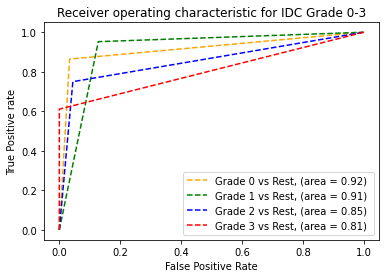

Selected model: EB0V2 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327

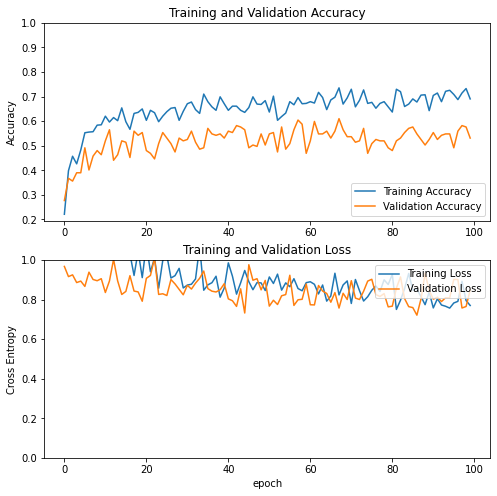

12/12 [==============================] - 0s 33ms/step - loss: 0.7575 - accuracy: 0.6102
Test accuracy : 0.6101694703102112
12/12 [==============================] - 1s 24ms/step
Confusion matrix, without normalization
[[64 47  5  2]
 [ 1 15  2  3]
 [ 1  7 11  1]
 [ 0  0  0 18]]
Normalized confusion matrix
[[0.54237288 0.39830508 0.04237288 0.01694915]
 [0.04761905 0.71428571 0.0952381  0.14285714]
 [0.05       0.35       0.55       0.05      ]
 [0.         0.         0.         1.        ]]

Accuracy: 0.6102


Balanced Accuracy: 0.7017

Macro Precision: 0.6370
Macro Recall: 0.7017
Macro F1-score: 0.6163

Kappa score: 0.4266

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.97      0.54      0.70       118
     Grade_1       0.22      0.71      0.33        21
     Grade_2       0.61      0.55      0.58        20
     Grade_3       0.75      1.00      0.86        18

    accuracy                           0.61       177
   macro avg       

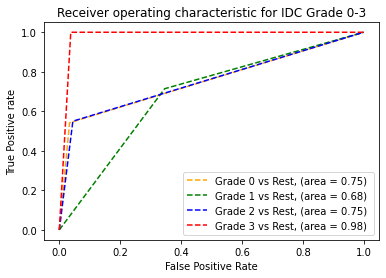

Selected model: EB0V2-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2-21k"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 256)        

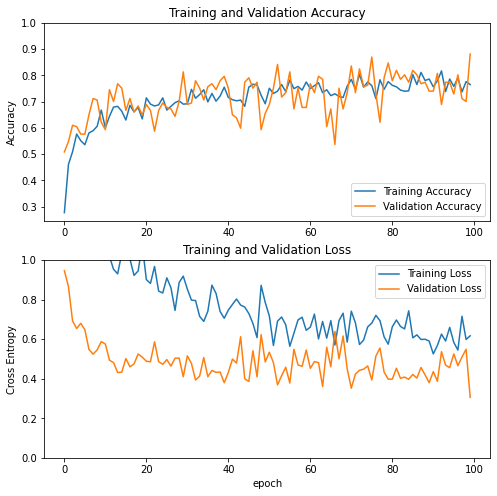

12/12 [==============================] - 0s 35ms/step - loss: 0.3062 - accuracy: 0.8814
Test accuracy : 0.8813559412956238
12/12 [==============================] - 1s 24ms/step
Confusion matrix, without normalization
[[105   3   5   5]
 [  0  16   2   3]
 [  0   2  18   0]
 [  0   0   1  17]]
Normalized confusion matrix
[[0.88983051 0.02542373 0.04237288 0.04237288]
 [0.         0.76190476 0.0952381  0.14285714]
 [0.         0.1        0.9        0.        ]
 [0.         0.         0.05555556 0.94444444]]

Accuracy: 0.8814


Balanced Accuracy: 0.8740

Macro Precision: 0.7836
Macro Recall: 0.8740
Macro F1-score: 0.8192

Kappa score: 0.7879

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.89      0.94       118
     Grade_1       0.76      0.76      0.76        21
     Grade_2       0.69      0.90      0.78        20
     Grade_3       0.68      0.94      0.79        18

    accuracy                           0.88       177
   

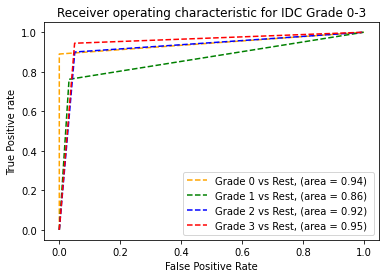

Selected model: RV1 : https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 2048)              23561152  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                              

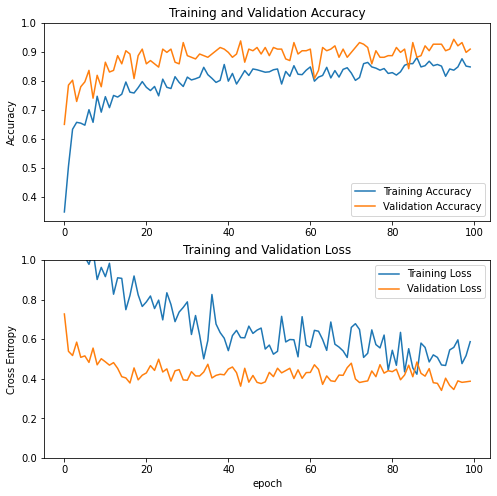

12/12 [==============================] - 1s 46ms/step - loss: 0.3456 - accuracy: 0.9435
Test accuracy : 0.9435028433799744
12/12 [==============================] - 1s 39ms/step
Confusion matrix, without normalization
[[116   2   0   0]
 [  0  17   0   4]
 [  0   1  18   1]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.98305085 0.01694915 0.         0.        ]
 [0.         0.80952381 0.         0.19047619]
 [0.         0.05       0.9        0.05      ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.9435


Balanced Accuracy: 0.8954

Macro Precision: 0.8797
Macro Recall: 0.8954
Macro F1-score: 0.8861

Kappa score: 0.8923

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.98      0.99       118
     Grade_1       0.81      0.81      0.81        21
     Grade_2       0.95      0.90      0.92        20
     Grade_3       0.76      0.89      0.82        18

    accuracy                           0.94       177
   

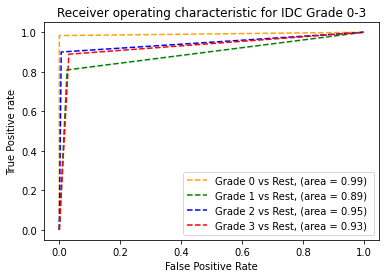

Selected model: RV2 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_4 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                              

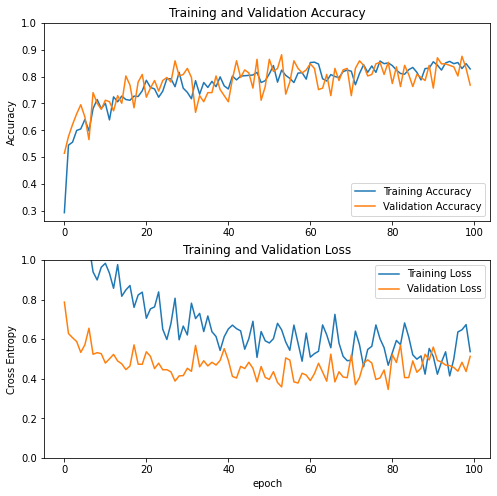

12/12 [==============================] - 1s 50ms/step - loss: 0.3587 - accuracy: 0.8814
Test accuracy : 0.8813559412956238
12/12 [==============================] - 1s 44ms/step
Confusion matrix, without normalization
[[107   6   2   3]
 [  0  17   1   3]
 [  0   3  17   0]
 [  0   1   2  15]]
Normalized confusion matrix
[[0.90677966 0.05084746 0.01694915 0.02542373]
 [0.         0.80952381 0.04761905 0.14285714]
 [0.         0.15       0.85       0.        ]
 [0.         0.05555556 0.11111111 0.83333333]]

Accuracy: 0.8814


Balanced Accuracy: 0.8499

Macro Precision: 0.7792
Macro Recall: 0.8499
Macro F1-score: 0.8095

Kappa score: 0.7854

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.91      0.95       118
     Grade_1       0.63      0.81      0.71        21
     Grade_2       0.77      0.85      0.81        20
     Grade_3       0.71      0.83      0.77        18

    accuracy                           0.88       177
   

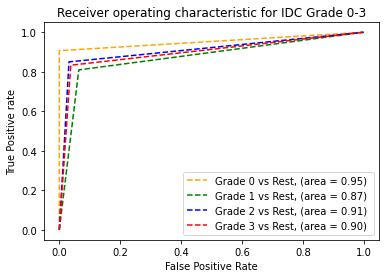

Selected model: MB1 : https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_5 (KerasLayer)  (None, 1024)              3228864   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
              

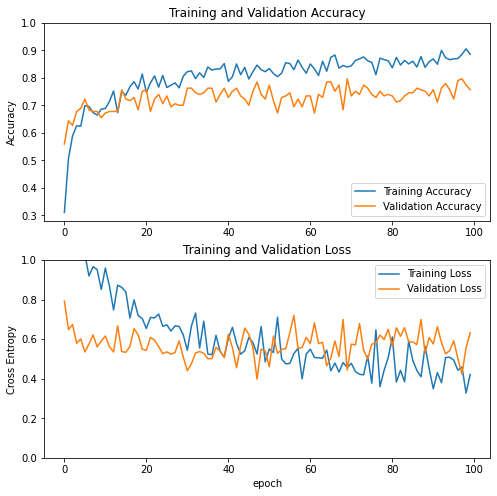

12/12 [==============================] - 0s 22ms/step - loss: 0.4436 - accuracy: 0.7966
Test accuracy : 0.7966101765632629
12/12 [==============================] - 0s 18ms/step
Confusion matrix, without normalization
[[92 11 10  5]
 [ 0 17  1  3]
 [ 0  3 17  0]
 [ 0  2  1 15]]
Normalized confusion matrix
[[0.77966102 0.09322034 0.08474576 0.04237288]
 [0.         0.80952381 0.04761905 0.14285714]
 [0.         0.15       0.85       0.        ]
 [0.         0.11111111 0.05555556 0.83333333]]

Accuracy: 0.7966


Balanced Accuracy: 0.8181

Macro Precision: 0.6884
Macro Recall: 0.8181
Macro F1-score: 0.7329

Kappa score: 0.6608

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.78      0.88       118
     Grade_1       0.52      0.81      0.63        21
     Grade_2       0.59      0.85      0.69        20
     Grade_3       0.65      0.83      0.73        18

    accuracy                           0.80       177
   macro avg       

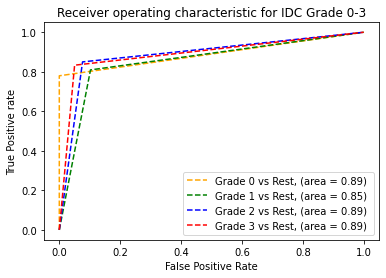

Selected model: MB2 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_6 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_12 (Dropout)        (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
              

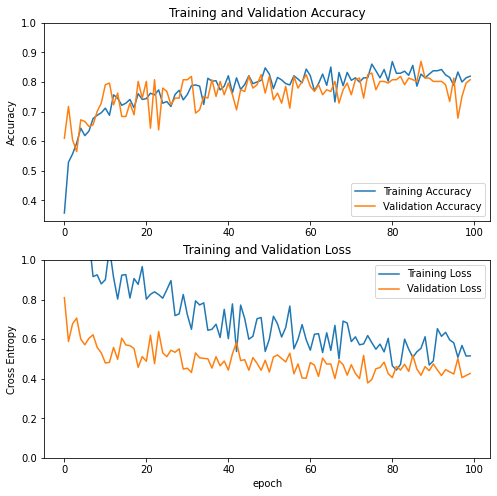

12/12 [==============================] - 0s 26ms/step - loss: 0.4172 - accuracy: 0.8701
Test accuracy : 0.8700565099716187
12/12 [==============================] - 1s 20ms/step
Confusion matrix, without normalization
[[105   9   0   4]
 [  0  15   3   3]
 [  0   3  17   0]
 [  0   0   1  17]]
Normalized confusion matrix
[[0.88983051 0.07627119 0.         0.03389831]
 [0.         0.71428571 0.14285714 0.14285714]
 [0.         0.15       0.85       0.        ]
 [0.         0.         0.05555556 0.94444444]]

Accuracy: 0.8701


Balanced Accuracy: 0.8496

Macro Precision: 0.7684
Macro Recall: 0.8496
Macro F1-score: 0.8014

Kappa score: 0.7676

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.89      0.94       118
     Grade_1       0.56      0.71      0.63        21
     Grade_2       0.81      0.85      0.83        20
     Grade_3       0.71      0.94      0.81        18

    accuracy                           0.87       177
   

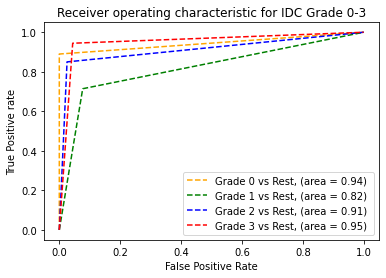

In [ ]:
model_list = ['EB0', 'EB0V2', 'EB0V2-21k', 'RV1', 'RV2', 'MB1', 'MB2']
train_dir =f'/content/{sn_label}_{temp_img}/Training Set'
test_dir =f'/content/{sn_label}_{temp_img}/Test Set'


train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size= IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode = 'categorical')

class_names = train_ds.class_names
print(class_names)

normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

y = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = generate_class_weights(y, multi_class=True, one_hot_encoded=True)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


for model_name in model_list:
  model = create_model(model_name, class_weights)


  best_weight_path = f'{best_weight_dir}/{model_name}_best.h5'
  cp_callback = tf.keras.callbacks.ModelCheckpoint(best_weight_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 


  history=model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=EPOCHS,
  callbacks = [cp_callback], 
  class_weight = class_weights
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_Train_Val_Curve.png')
  plt.show()
  plt.close()

  model.load_weights(best_weight_path)

  loss, accuracy = model.evaluate(test_ds)
  print('Test accuracy :', accuracy)

  test_labels = np.concatenate([y for x, y in test_ds], axis=0)
  predictions = model.predict(test_ds)
  y_pred = np.argmax(predictions, axis=1)
  y_label = np.argmax(test_labels, axis=1)

  cm = confusion_matrix(y_label, y_pred)
  plot_confusion_matrix(cm, classes= class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM.png' )
  plot_confusion_matrix(cm, normalize = True, classes = class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM_Norm.png')


  print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
  print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

  print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
  print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
  print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
  print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

  print('\nClassification Report\n')
  print(classification_report(y_label, y_pred, target_names=class_names))

  baccuracy = round(balanced_accuracy_score(y_label, y_pred), 4)
  macro_precision = round(precision_score(y_label, y_pred, average='macro'), 4)
  macro_recall = round(recall_score(y_label, y_pred, average='macro'), 4)
  macro_f1score = round(f1_score(y_label, y_pred, average='macro'), 4)
  kappa_score = round(cohen_kappa_score(y_label, y_pred), 4)

  y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
  y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

  # Plot ROC Curve
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = 4
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])


  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
  plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
  plt.title('Receiver operating characteristic for IDC Grade 0-3')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_ROC.png')
  plt.show()
  plt.close()



  df = pd.DataFrame({'Model Name': model_name, 'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score}, index=[0])  

  df.to_csv(result_dir,  mode='a', index=False, header=False) 


# Temp 2

# Setup SN Dataset

In [ ]:
# Reinhard
sn_label = 'V'
temp_img = 'Temp2'

# original dataset
base_path = "/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset"

# temp image path
temp_img_path = f"/content/drive/Shareddrives/Unlimited Drive/SN/Template/{temp_img}.png"

#  make a temp directory to save SN dataset
save_path = f'/content/{sn_label}_{temp_img}'
if not os.path.exists(save_path):
  os.mkdir(save_path)

# Setup Model

In [ ]:
# Set hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100
print('Batch size:', BATCH_SIZE, 'Epoch: ', EPOCHS)

best_weight_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Weight/{sn_label}_{temp_img}'
if not os.path.exists(best_weight_dir):
   os.mkdir(best_weight_dir)

   
figure_dir = '/content/drive/Shareddrives/Unlimited Drive/SN/Result/Figures'




metrics = {'Model Name': [], 'Balanced Accuracy': [], 'Macro Precision': [], 'Macro Recall': [], 'Macro F1score': [], 'Kappa Score': []}
result_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Result/{sn_label}_{temp_img}_result.csv'
if not os.path.exists(result_dir):
  df = pd.DataFrame(metrics) 
  df.to_csv(result_dir, index=False) 

Batch size: 16 Epoch:  100


# Form SN datasets

In [ ]:
# Define normalizer
normalizer = staintools.StainNormalizer(method="vahadane")

# Read template image
print(temp_img_path)
normalizer.fit(staintools.read_image(temp_img_path))

print(f'Folder contains {len(os.listdir(base_path))} folders')
print(os.listdir(base_path))

print('')

for type_folder in os.listdir(base_path):
  type_path = os.path.join(base_path, type_folder)
  print(f'In Folder :{type_path}')
  print('')

  for grade_folder in os.listdir(type_path):
    grade_path = os.path.join(type_path, grade_folder)
    print(f'In Folder :{grade_path}')
    print('')

    for files in os.listdir(grade_path):
      
      image_path = os.path.join(grade_path, files)
      im = normalizer.transform(staintools.read_image(image_path))


      saveim_path = os.path.join(save_path, type_folder, grade_folder)
      if not os.path.exists(saveim_path):
        os.makedirs(saveim_path)

        
      os.chdir(saveim_path) 
      file_name = str(files)
      cv.imwrite(file_name,im)

 

/content/drive/Shareddrives/Unlimited Drive/SN/Template/Temp2.png
Folder contains 2 folders
['Training Set', 'Test Set']

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_3

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_0 

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_0

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/T

# Train and Test Models

Found 711 files belonging to 4 classes.
Found 177 files belonging to 4 classes.
['Grade_0 ', 'Grade_1', 'Grade_2', 'Grade_3']
Selected model: EB0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Building model with https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_7 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dropout_14 (Dropout)        (None, 1280)              0         
                                        

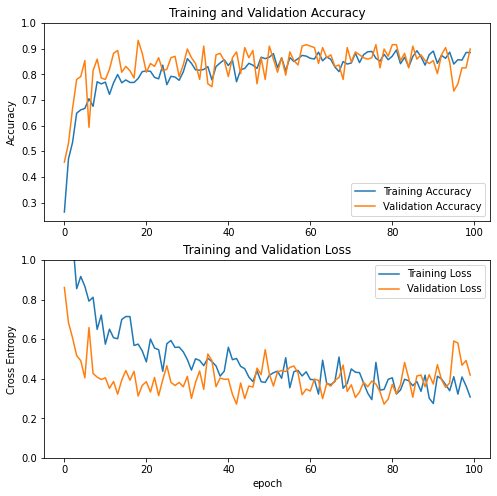

12/12 [==============================] - 0s 37ms/step - loss: 0.3125 - accuracy: 0.9322
Test accuracy : 0.9322034120559692
12/12 [==============================] - 1s 29ms/step
Confusion matrix, without normalization
[[112   3   2   1]
 [  0  20   0   1]
 [  0   1  19   0]
 [  0   3   1  14]]
Normalized confusion matrix
[[0.94915254 0.02542373 0.01694915 0.00847458]
 [0.         0.95238095 0.         0.04761905]
 [0.         0.05       0.95       0.        ]
 [0.         0.16666667 0.05555556 0.77777778]]

Accuracy: 0.9322


Balanced Accuracy: 0.9073

Macro Precision: 0.8698
Macro Recall: 0.9073
Macro F1-score: 0.8839

Kappa score: 0.8737

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.95      0.97       118
     Grade_1       0.74      0.95      0.83        21
     Grade_2       0.86      0.95      0.90        20
     Grade_3       0.88      0.78      0.82        18

    accuracy                           0.93       177
   

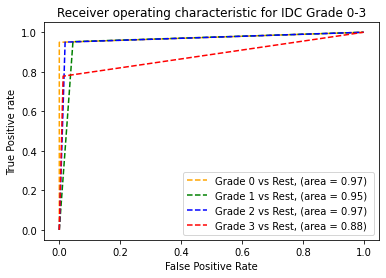

Selected model: EB0V2 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_8 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dropout_16 (Dropout)        (None, 1280)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               327

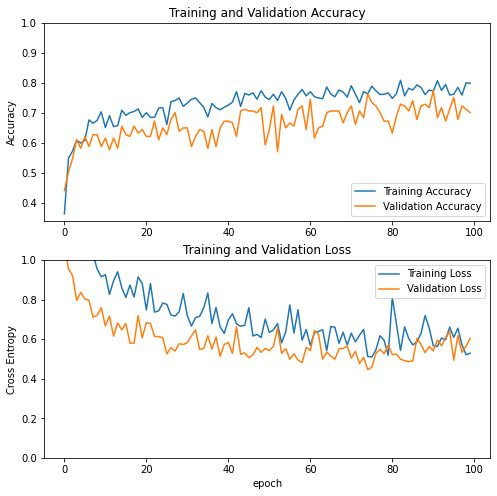

12/12 [==============================] - 0s 31ms/step - loss: 0.5405 - accuracy: 0.7740
Test accuracy : 0.7740113139152527
12/12 [==============================] - 1s 24ms/step
Confusion matrix, without normalization
[[91 23  2  2]
 [ 2 16  0  3]
 [ 2  3 15  0]
 [ 0  2  1 15]]
Normalized confusion matrix
[[0.77118644 0.19491525 0.01694915 0.01694915]
 [0.0952381  0.76190476 0.         0.14285714]
 [0.1        0.15       0.75       0.        ]
 [0.         0.11111111 0.05555556 0.83333333]]

Accuracy: 0.7740


Balanced Accuracy: 0.7791

Macro Precision: 0.7262
Macro Recall: 0.7791
Macro F1-score: 0.7314

Kappa score: 0.6168

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.96      0.77      0.85       118
     Grade_1       0.36      0.76      0.49        21
     Grade_2       0.83      0.75      0.79        20
     Grade_3       0.75      0.83      0.79        18

    accuracy                           0.77       177
   macro avg       

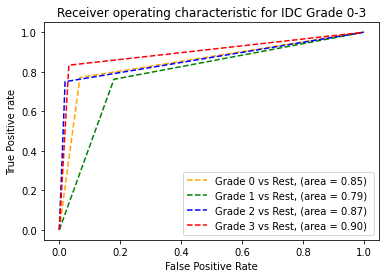

Selected model: EB0V2-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2-21k"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_9 (KerasLayer)  (None, 1280)              5919312   
                                                                 
 dropout_18 (Dropout)        (None, 1280)              0         
                                                                 
 dense_18 (Dense)            (None, 256)        

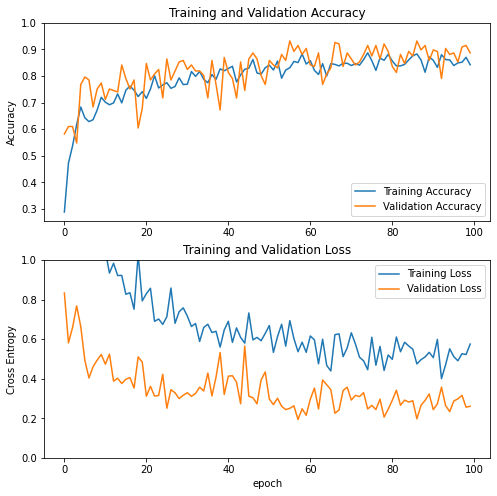

12/12 [==============================] - 0s 35ms/step - loss: 0.2503 - accuracy: 0.9322
Test accuracy : 0.9322034120559692
12/12 [==============================] - 1s 29ms/step
Confusion matrix, without normalization
[[114   4   0   0]
 [  0  20   0   1]
 [  0   3  17   0]
 [  0   3   1  14]]
Normalized confusion matrix
[[0.96610169 0.03389831 0.         0.        ]
 [0.         0.95238095 0.         0.04761905]
 [0.         0.15       0.85       0.        ]
 [0.         0.16666667 0.05555556 0.77777778]]

Accuracy: 0.9322


Balanced Accuracy: 0.8866

Macro Precision: 0.8861
Macro Recall: 0.8866
Macro F1-score: 0.8776

Kappa score: 0.8722

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.97      0.98       118
     Grade_1       0.67      0.95      0.78        21
     Grade_2       0.94      0.85      0.89        20
     Grade_3       0.93      0.78      0.85        18

    accuracy                           0.93       177
   

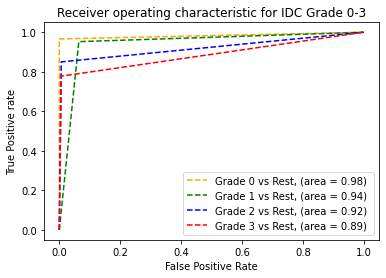

Selected model: RV1 : https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_10 (KerasLayer)  (None, 2048)             23561152  
                                                                 
 dropout_20 (Dropout)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               524544    
                              

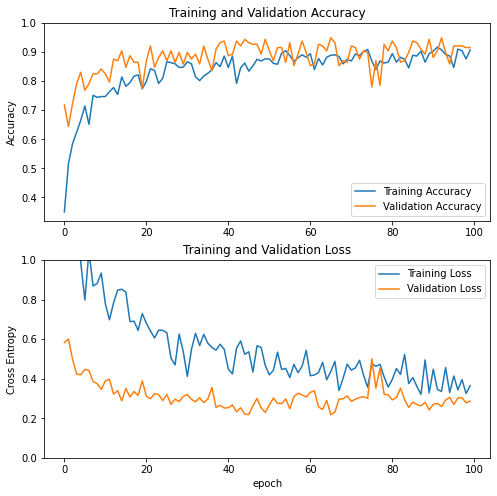

12/12 [==============================] - 1s 46ms/step - loss: 0.2179 - accuracy: 0.9492
Test accuracy : 0.9491525292396545
12/12 [==============================] - 1s 39ms/step
Confusion matrix, without normalization
[[116   1   0   1]
 [  0  18   0   3]
 [  0   2  18   0]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.98305085 0.00847458 0.         0.00847458]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.1        0.9        0.        ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.9492


Balanced Accuracy: 0.9073

Macro Precision: 0.8914
Macro Recall: 0.9073
Macro F1-score: 0.8985

Kappa score: 0.9031

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.98      0.99       118
     Grade_1       0.82      0.86      0.84        21
     Grade_2       0.95      0.90      0.92        20
     Grade_3       0.80      0.89      0.84        18

    accuracy                           0.95       177
   

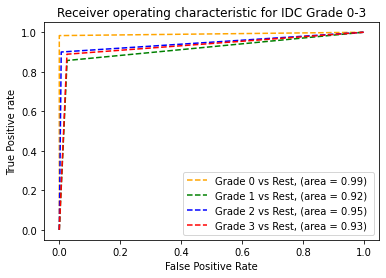

Selected model: RV2 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_11 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_11 (KerasLayer)  (None, 2048)             23564800  
                                                                 
 dropout_22 (Dropout)        (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               524544    
                              

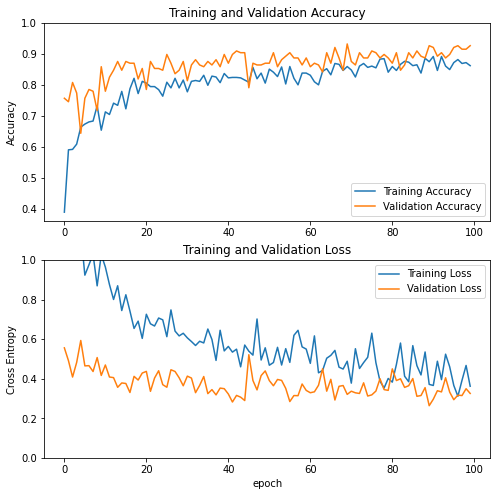

12/12 [==============================] - 1s 52ms/step - loss: 0.3208 - accuracy: 0.9322
Test accuracy : 0.9322034120559692
12/12 [==============================] - 1s 44ms/step
Confusion matrix, without normalization
[[115   3   0   0]
 [  0  18   0   3]
 [  0   4  16   0]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.97457627 0.02542373 0.         0.        ]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.2        0.8        0.        ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.9322


Balanced Accuracy: 0.8802

Macro Precision: 0.8689
Macro Recall: 0.8802
Macro F1-score: 0.8707

Kappa score: 0.8715

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.97      0.99       118
     Grade_1       0.69      0.86      0.77        21
     Grade_2       0.94      0.80      0.86        20
     Grade_3       0.84      0.89      0.86        18

    accuracy                           0.93       177
   

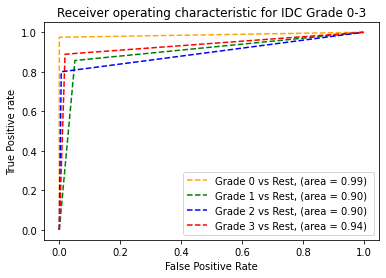

Selected model: MB1 : https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_12 (KerasLayer)  (None, 1024)             3228864   
                                                                 
 dropout_24 (Dropout)        (None, 1024)              0         
                                                                 
 dense_24 (Dense)            (None, 256)               262400    
              

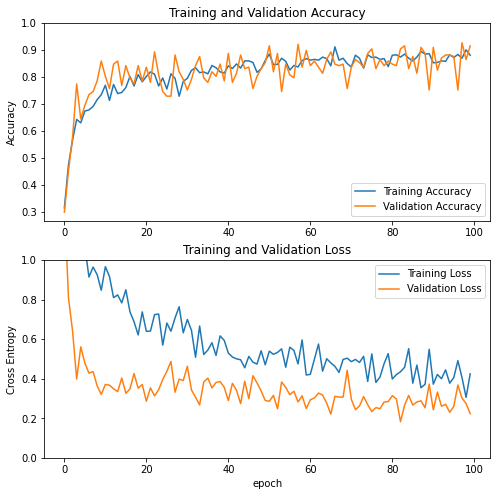

12/12 [==============================] - 0s 19ms/step - loss: 0.3021 - accuracy: 0.9266
Test accuracy : 0.9265536665916443
12/12 [==============================] - 0s 16ms/step
Confusion matrix, without normalization
[[114   2   2   0]
 [  0  18   0   3]
 [  0   4  16   0]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.96610169 0.01694915 0.01694915 0.        ]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.2        0.8        0.        ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.9266


Balanced Accuracy: 0.8780

Macro Precision: 0.8511
Macro Recall: 0.8780
Macro F1-score: 0.8627

Kappa score: 0.8616

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.97      0.98       118
     Grade_1       0.72      0.86      0.78        21
     Grade_2       0.84      0.80      0.82        20
     Grade_3       0.84      0.89      0.86        18

    accuracy                           0.93       177
   

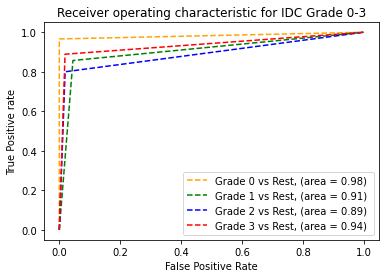

Selected model: MB2 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_13 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dropout_26 (Dropout)        (None, 1280)              0         
                                                                 
 dense_26 (Dense)            (None, 256)               327936    
              

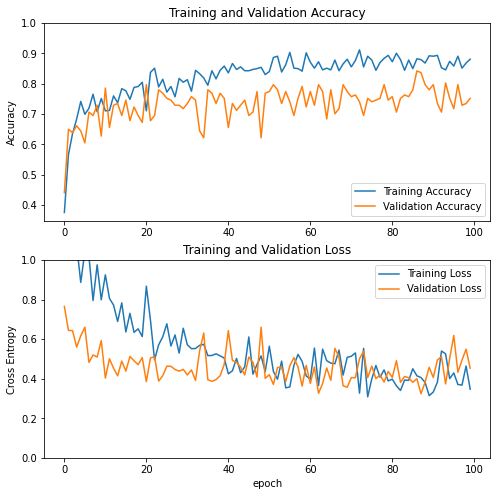

12/12 [==============================] - 0s 26ms/step - loss: 0.4001 - accuracy: 0.8418
Test accuracy : 0.8418079018592834
12/12 [==============================] - 1s 20ms/step
Confusion matrix, without normalization
[[101  16   1   0]
 [  0  18   0   3]
 [  0   4  16   0]
 [  0   2   2  14]]
Normalized confusion matrix
[[0.8559322  0.13559322 0.00847458 0.        ]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.2        0.8        0.        ]
 [0.         0.11111111 0.11111111 0.77777778]]

Accuracy: 0.8418


Balanced Accuracy: 0.8227

Macro Precision: 0.7789
Macro Recall: 0.8227
Macro F1-score: 0.7833

Kappa score: 0.7229

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.86      0.92       118
     Grade_1       0.45      0.86      0.59        21
     Grade_2       0.84      0.80      0.82        20
     Grade_3       0.82      0.78      0.80        18

    accuracy                           0.84       177
   

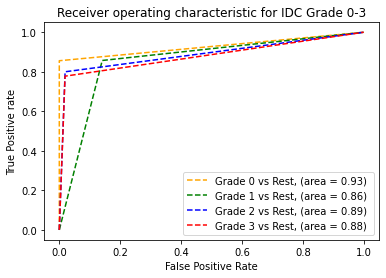

In [ ]:
model_list = ['EB0', 'EB0V2', 'EB0V2-21k', 'RV1', 'RV2', 'MB1', 'MB2']
train_dir =f'/content/{sn_label}_{temp_img}/Training Set'
test_dir =f'/content/{sn_label}_{temp_img}/Test Set'


train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size= IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode = 'categorical')

class_names = train_ds.class_names
print(class_names)

normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

y = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = generate_class_weights(y, multi_class=True, one_hot_encoded=True)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


for model_name in model_list:
  model = create_model(model_name, class_weights)


  best_weight_path = f'{best_weight_dir}/{model_name}_best.h5'
  cp_callback = tf.keras.callbacks.ModelCheckpoint(best_weight_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 


  history=model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=EPOCHS,
  callbacks = [cp_callback], 
  class_weight = class_weights
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_Train_Val_Curve.png')
  plt.show()
  plt.close()

  model.load_weights(best_weight_path)

  loss, accuracy = model.evaluate(test_ds)
  print('Test accuracy :', accuracy)

  test_labels = np.concatenate([y for x, y in test_ds], axis=0)
  predictions = model.predict(test_ds)
  y_pred = np.argmax(predictions, axis=1)
  y_label = np.argmax(test_labels, axis=1)

  cm = confusion_matrix(y_label, y_pred)
  plot_confusion_matrix(cm, classes= class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM.png' )
  plot_confusion_matrix(cm, normalize = True, classes = class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM_Norm.png')


  print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
  print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

  print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
  print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
  print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
  print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

  print('\nClassification Report\n')
  print(classification_report(y_label, y_pred, target_names=class_names))

  baccuracy = round(balanced_accuracy_score(y_label, y_pred), 4)
  macro_precision = round(precision_score(y_label, y_pred, average='macro'), 4)
  macro_recall = round(recall_score(y_label, y_pred, average='macro'), 4)
  macro_f1score = round(f1_score(y_label, y_pred, average='macro'), 4)
  kappa_score = round(cohen_kappa_score(y_label, y_pred), 4)

  y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
  y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

  # Plot ROC Curve
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = 4
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])


  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
  plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
  plt.title('Receiver operating characteristic for IDC Grade 0-3')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_ROC.png')
  plt.show()
  plt.close()



  df = pd.DataFrame({'Model Name': model_name, 'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score}, index=[0])  

  df.to_csv(result_dir,  mode='a', index=False, header=False) 


# Temp 3

# Setup SN Dataset

In [ ]:
# Reinhard
sn_label = 'V'
temp_img = 'Temp3'

# original dataset
base_path = "/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset"

# temp image path
temp_img_path = f"/content/drive/Shareddrives/Unlimited Drive/SN/Template/{temp_img}.png"

#  make a temp directory to save SN dataset
save_path = f'/content/{sn_label}_{temp_img}'
if not os.path.exists(save_path):
  os.mkdir(save_path)

# Setup Model

In [ ]:
# Set hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100
print('Batch size:', BATCH_SIZE, 'Epoch: ', EPOCHS)

best_weight_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Weight/{sn_label}_{temp_img}'
if not os.path.exists(best_weight_dir):
   os.mkdir(best_weight_dir)

   
figure_dir = '/content/drive/Shareddrives/Unlimited Drive/SN/Result/Figures'




metrics = {'Model Name': [], 'Balanced Accuracy': [], 'Macro Precision': [], 'Macro Recall': [], 'Macro F1score': [], 'Kappa Score': []}
result_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Result/{sn_label}_{temp_img}_result.csv'
if not os.path.exists(result_dir):
  df = pd.DataFrame(metrics) 
  df.to_csv(result_dir, index=False) 

Batch size: 16 Epoch:  100


# Form SN datasets

In [ ]:
# Define normalizer
normalizer = staintools.StainNormalizer(method="vahadane")

# Read template image
print(temp_img_path)
normalizer.fit(staintools.read_image(temp_img_path))

print(f'Folder contains {len(os.listdir(base_path))} folders')
print(os.listdir(base_path))

print('')

for type_folder in os.listdir(base_path):
  type_path = os.path.join(base_path, type_folder)
  print(f'In Folder :{type_path}')
  print('')

  for grade_folder in os.listdir(type_path):
    grade_path = os.path.join(type_path, grade_folder)
    print(f'In Folder :{grade_path}')
    print('')

    for files in os.listdir(grade_path):
      
      image_path = os.path.join(grade_path, files)
      im = normalizer.transform(staintools.read_image(image_path))


      saveim_path = os.path.join(save_path, type_folder, grade_folder)
      if not os.path.exists(saveim_path):
        os.makedirs(saveim_path)

        
      os.chdir(saveim_path) 
      file_name = str(files)
      cv.imwrite(file_name,im)

 

/content/drive/Shareddrives/Unlimited Drive/SN/Template/Temp3.png
Folder contains 2 folders
['Training Set', 'Test Set']

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_3

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_0 

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_0

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/T

# Train and Test Models

Found 711 files belonging to 4 classes.
Found 177 files belonging to 4 classes.
['Grade_0 ', 'Grade_1', 'Grade_2', 'Grade_3']
Selected model: EB0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Building model with https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_14 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_14 (KerasLayer)  (None, 1280)             4049564   
                                                                 
 dropout_28 (Dropout)        (None, 1280)              0         
                                        

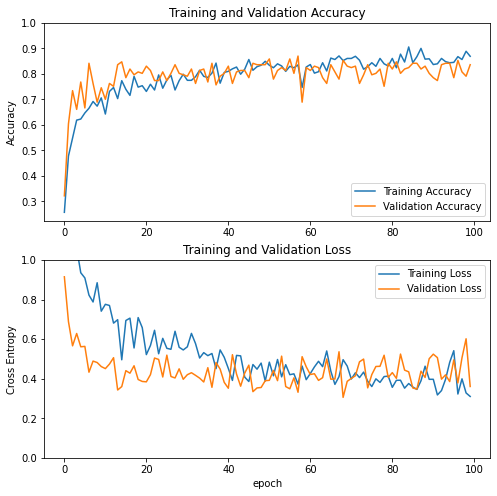

12/12 [==============================] - 0s 37ms/step - loss: 0.3315 - accuracy: 0.8701
Test accuracy : 0.8700565099716187
12/12 [==============================] - 1s 29ms/step
Confusion matrix, without normalization
[[101   8   7   2]
 [  0  18   0   3]
 [  0   1  19   0]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.8559322  0.06779661 0.05932203 0.01694915]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.05       0.95       0.        ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.8701


Balanced Accuracy: 0.8880

Macro Precision: 0.7771
Macro Recall: 0.8880
Macro F1-score: 0.8215

Kappa score: 0.7726

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.86      0.92       118
     Grade_1       0.64      0.86      0.73        21
     Grade_2       0.70      0.95      0.81        20
     Grade_3       0.76      0.89      0.82        18

    accuracy                           0.87       177
   

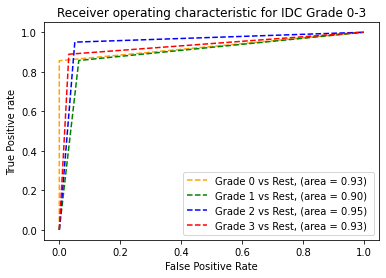

Selected model: EB0V2 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_15 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_15 (KerasLayer)  (None, 1280)             5919312   
                                                                 
 dropout_30 (Dropout)        (None, 1280)              0         
                                                                 
 dense_30 (Dense)            (None, 256)               327

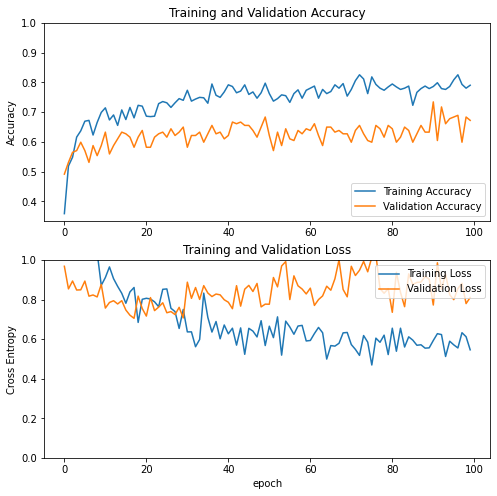

12/12 [==============================] - 0s 33ms/step - loss: 0.7729 - accuracy: 0.7345
Test accuracy : 0.7344632744789124
12/12 [==============================] - 1s 25ms/step
Confusion matrix, without normalization
[[87 22  2  7]
 [ 3 15  0  3]
 [ 2  6 12  0]
 [ 0  1  1 16]]
Normalized confusion matrix
[[0.73728814 0.18644068 0.01694915 0.05932203]
 [0.14285714 0.71428571 0.         0.14285714]
 [0.1        0.3        0.6        0.        ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.7345


Balanced Accuracy: 0.7351

Macro Precision: 0.6755
Macro Recall: 0.7351
Macro F1-score: 0.6758

Kappa score: 0.5571

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.95      0.74      0.83       118
     Grade_1       0.34      0.71      0.46        21
     Grade_2       0.80      0.60      0.69        20
     Grade_3       0.62      0.89      0.73        18

    accuracy                           0.73       177
   macro avg       

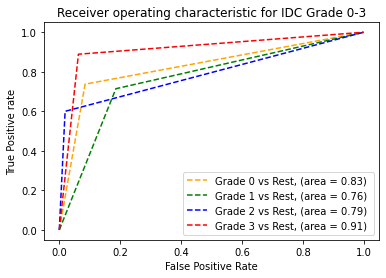

Selected model: EB0V2-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2-21k"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_16 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_16 (KerasLayer)  (None, 1280)             5919312   
                                                                 
 dropout_32 (Dropout)        (None, 1280)              0         
                                                                 
 dense_32 (Dense)            (None, 256)        

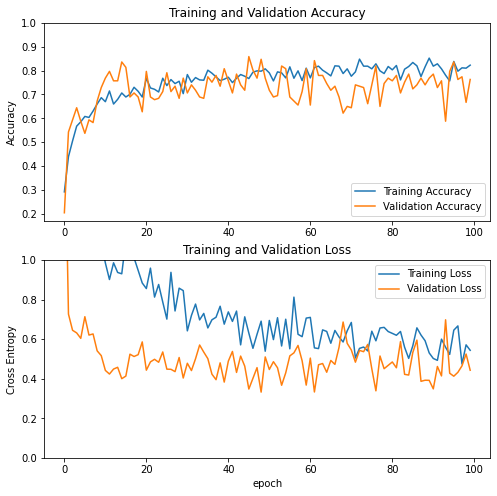

12/12 [==============================] - 0s 34ms/step - loss: 0.3479 - accuracy: 0.8588
Test accuracy : 0.8587570786476135
12/12 [==============================] - 1s 25ms/step
Confusion matrix, without normalization
[[103  11   2   2]
 [  0  18   0   3]
 [  0   4  16   0]
 [  0   2   1  15]]
Normalized confusion matrix
[[0.87288136 0.09322034 0.01694915 0.01694915]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.2        0.8        0.        ]
 [0.         0.11111111 0.05555556 0.83333333]]

Accuracy: 0.8588


Balanced Accuracy: 0.8408

Macro Precision: 0.7766
Macro Recall: 0.8408
Macro F1-score: 0.7962

Kappa score: 0.7500

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.87      0.93       118
     Grade_1       0.51      0.86      0.64        21
     Grade_2       0.84      0.80      0.82        20
     Grade_3       0.75      0.83      0.79        18

    accuracy                           0.86       177
   

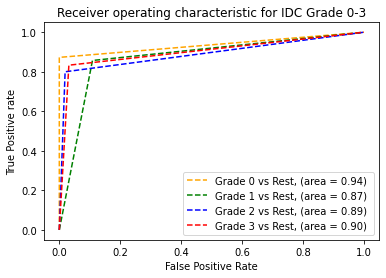

Selected model: RV1 : https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_17 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_17 (KerasLayer)  (None, 2048)             23561152  
                                                                 
 dropout_34 (Dropout)        (None, 2048)              0         
                                                                 
 dense_34 (Dense)            (None, 256)               524544    
                              

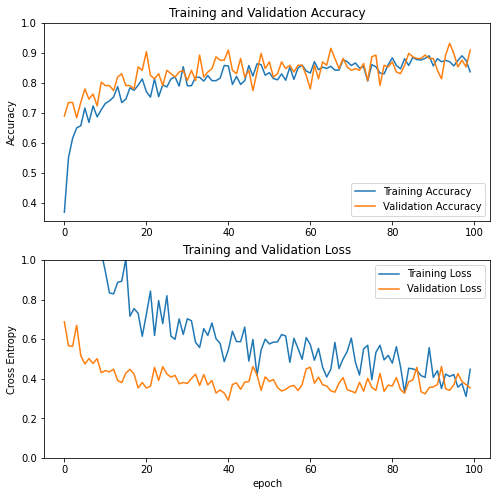

12/12 [==============================] - 1s 45ms/step - loss: 0.3413 - accuracy: 0.9322
Test accuracy : 0.9322034120559692
12/12 [==============================] - 1s 39ms/step
Confusion matrix, without normalization
[[114   2   0   2]
 [  0  18   0   3]
 [  0   2  18   0]
 [  0   2   1  15]]
Normalized confusion matrix
[[0.96610169 0.01694915 0.         0.01694915]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.1        0.9        0.        ]
 [0.         0.11111111 0.05555556 0.83333333]]

Accuracy: 0.9322


Balanced Accuracy: 0.8891

Macro Precision: 0.8618
Macro Recall: 0.8891
Macro F1-score: 0.8738

Kappa score: 0.8723

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.97      0.98       118
     Grade_1       0.75      0.86      0.80        21
     Grade_2       0.95      0.90      0.92        20
     Grade_3       0.75      0.83      0.79        18

    accuracy                           0.93       177
   

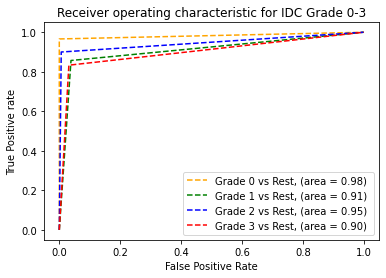

Selected model: RV2 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_18 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_18 (KerasLayer)  (None, 2048)             23564800  
                                                                 
 dropout_36 (Dropout)        (None, 2048)              0         
                                                                 
 dense_36 (Dense)            (None, 256)               524544    
                              

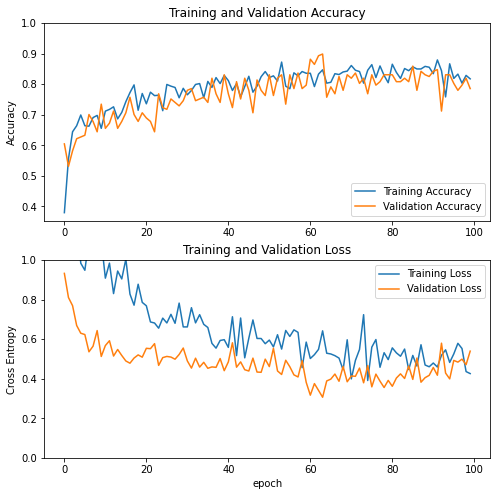

12/12 [==============================] - 1s 50ms/step - loss: 0.3064 - accuracy: 0.8983
Test accuracy : 0.8983050584793091
12/12 [==============================] - 1s 44ms/step
Confusion matrix, without normalization
[[107   7   2   2]
 [  0  19   0   2]
 [  0   3  17   0]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.90677966 0.05932203 0.01694915 0.01694915]
 [0.         0.9047619  0.         0.0952381 ]
 [0.         0.15       0.85       0.        ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.8983


Balanced Accuracy: 0.8876

Macro Precision: 0.8208
Macro Recall: 0.8876
Macro F1-score: 0.8471

Kappa score: 0.8160

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.91      0.95       118
     Grade_1       0.63      0.90      0.75        21
     Grade_2       0.85      0.85      0.85        20
     Grade_3       0.80      0.89      0.84        18

    accuracy                           0.90       177
   

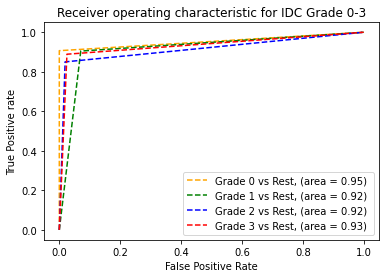

Selected model: MB1 : https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_19 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_19 (KerasLayer)  (None, 1024)             3228864   
                                                                 
 dropout_38 (Dropout)        (None, 1024)              0         
                                                                 
 dense_38 (Dense)            (None, 256)               262400    
              

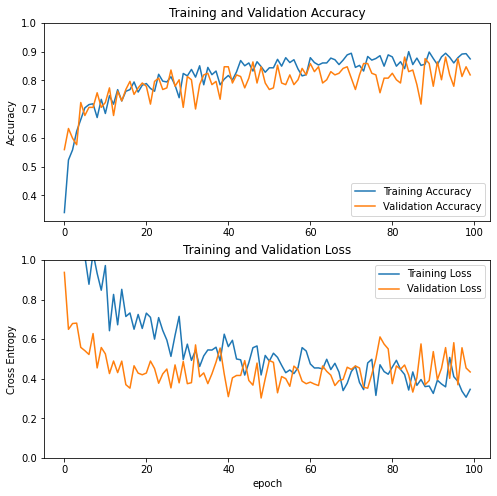

12/12 [==============================] - 0s 24ms/step - loss: 0.4694 - accuracy: 0.8814
Test accuracy : 0.8813559412956238
12/12 [==============================] - 0s 16ms/step
Confusion matrix, without normalization
[[109   4   5   0]
 [  0  18   0   3]
 [  0   5  15   0]
 [  0   2   2  14]]
Normalized confusion matrix
[[0.92372881 0.03389831 0.04237288 0.        ]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.25       0.75       0.        ]
 [0.         0.11111111 0.11111111 0.77777778]]

Accuracy: 0.8814


Balanced Accuracy: 0.8272

Macro Precision: 0.7815
Macro Recall: 0.8272
Macro F1-score: 0.7987

Kappa score: 0.7828

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.92      0.96       118
     Grade_1       0.62      0.86      0.72        21
     Grade_2       0.68      0.75      0.71        20
     Grade_3       0.82      0.78      0.80        18

    accuracy                           0.88       177
   

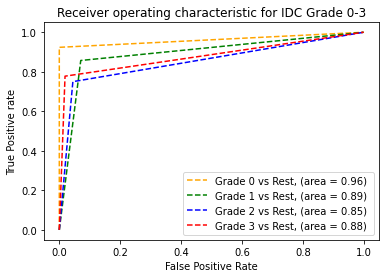

Selected model: MB2 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_20 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_20 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dropout_40 (Dropout)        (None, 1280)              0         
                                                                 
 dense_40 (Dense)            (None, 256)               327936    
              

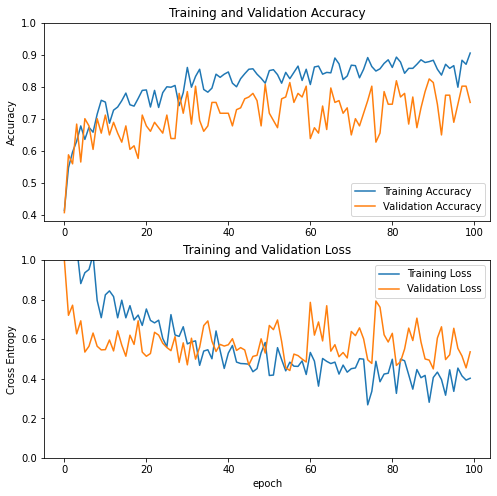

12/12 [==============================] - 0s 25ms/step - loss: 0.4942 - accuracy: 0.8249
Test accuracy : 0.8248587846755981
12/12 [==============================] - 1s 20ms/step
Confusion matrix, without normalization
[[93 11  6  8]
 [ 0 18  0  3]
 [ 0  1 19  0]
 [ 0  2  0 16]]
Normalized confusion matrix
[[0.78813559 0.09322034 0.05084746 0.06779661]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.05       0.95       0.        ]
 [0.         0.11111111 0.         0.88888889]]

Accuracy: 0.8249


Balanced Accuracy: 0.8710

Macro Precision: 0.7288
Macro Recall: 0.8710
Macro F1-score: 0.7791

Kappa score: 0.7065

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.79      0.88       118
     Grade_1       0.56      0.86      0.68        21
     Grade_2       0.76      0.95      0.84        20
     Grade_3       0.59      0.89      0.71        18

    accuracy                           0.82       177
   macro avg       

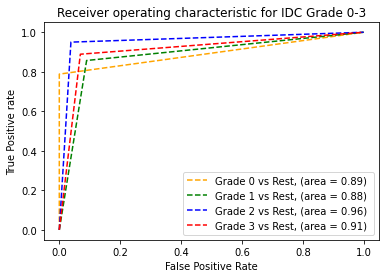

In [ ]:
model_list = ['EB0', 'EB0V2', 'EB0V2-21k', 'RV1', 'RV2', 'MB1', 'MB2']
train_dir =f'/content/{sn_label}_{temp_img}/Training Set'
test_dir =f'/content/{sn_label}_{temp_img}/Test Set'


train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size= IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode = 'categorical')

class_names = train_ds.class_names
print(class_names)

normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

y = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = generate_class_weights(y, multi_class=True, one_hot_encoded=True)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


for model_name in model_list:
  model = create_model(model_name, class_weights)


  best_weight_path = f'{best_weight_dir}/{model_name}_best.h5'
  cp_callback = tf.keras.callbacks.ModelCheckpoint(best_weight_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 


  history=model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=EPOCHS,
  callbacks = [cp_callback], 
  class_weight = class_weights
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_Train_Val_Curve.png')
  plt.show()
  plt.close()

  model.load_weights(best_weight_path)

  loss, accuracy = model.evaluate(test_ds)
  print('Test accuracy :', accuracy)

  test_labels = np.concatenate([y for x, y in test_ds], axis=0)
  predictions = model.predict(test_ds)
  y_pred = np.argmax(predictions, axis=1)
  y_label = np.argmax(test_labels, axis=1)

  cm = confusion_matrix(y_label, y_pred)
  plot_confusion_matrix(cm, classes= class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM.png' )
  plot_confusion_matrix(cm, normalize = True, classes = class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM_Norm.png')


  print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
  print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

  print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
  print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
  print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
  print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

  print('\nClassification Report\n')
  print(classification_report(y_label, y_pred, target_names=class_names))

  baccuracy = round(balanced_accuracy_score(y_label, y_pred), 4)
  macro_precision = round(precision_score(y_label, y_pred, average='macro'), 4)
  macro_recall = round(recall_score(y_label, y_pred, average='macro'), 4)
  macro_f1score = round(f1_score(y_label, y_pred, average='macro'), 4)
  kappa_score = round(cohen_kappa_score(y_label, y_pred), 4)

  y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
  y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

  # Plot ROC Curve
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = 4
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])


  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
  plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
  plt.title('Receiver operating characteristic for IDC Grade 0-3')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_ROC.png')
  plt.show()
  plt.close()



  df = pd.DataFrame({'Model Name': model_name, 'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score}, index=[0])  

  df.to_csv(result_dir,  mode='a', index=False, header=False) 


# Temp 4


# Setup SN Dataset

In [ ]:
# Reinhard
sn_label = 'V'
temp_img = 'Temp4'

# original dataset
base_path = "/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset"

# temp image path
temp_img_path = f"/content/drive/Shareddrives/Unlimited Drive/SN/Template/{temp_img}.png"

#  make a temp directory to save SN dataset
save_path = f'/content/{sn_label}_{temp_img}'
if not os.path.exists(save_path):
  os.mkdir(save_path)

# Setup Model

In [ ]:
# Set hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100
print('Batch size:', BATCH_SIZE, 'Epoch: ', EPOCHS)

best_weight_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Weight/{sn_label}_{temp_img}'
if not os.path.exists(best_weight_dir):
   os.mkdir(best_weight_dir)

   
figure_dir = '/content/drive/Shareddrives/Unlimited Drive/SN/Result/Figures'




metrics = {'Model Name': [], 'Balanced Accuracy': [], 'Macro Precision': [], 'Macro Recall': [], 'Macro F1score': [], 'Kappa Score': []}
result_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Result/{sn_label}_{temp_img}_result.csv'
if not os.path.exists(result_dir):
  df = pd.DataFrame(metrics) 
  df.to_csv(result_dir, index=False) 

Batch size: 16 Epoch:  100


# Form SN datasets

In [ ]:
# Define normalizer
normalizer = staintools.StainNormalizer(method="vahadane")

# Read template image
print(temp_img_path)
normalizer.fit(staintools.read_image(temp_img_path))

print(f'Folder contains {len(os.listdir(base_path))} folders')
print(os.listdir(base_path))

print('')

for type_folder in os.listdir(base_path):
  type_path = os.path.join(base_path, type_folder)
  print(f'In Folder :{type_path}')
  print('')

  for grade_folder in os.listdir(type_path):
    grade_path = os.path.join(type_path, grade_folder)
    print(f'In Folder :{grade_path}')
    print('')

    for files in os.listdir(grade_path):
      
      image_path = os.path.join(grade_path, files)
      im = normalizer.transform(staintools.read_image(image_path))


      saveim_path = os.path.join(save_path, type_folder, grade_folder)
      if not os.path.exists(saveim_path):
        os.makedirs(saveim_path)

        
      os.chdir(saveim_path) 
      file_name = str(files)
      cv.imwrite(file_name,im)

 

/content/drive/Shareddrives/Unlimited Drive/SN/Template/Temp4.png
Folder contains 2 folders
['Training Set', 'Test Set']

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_3

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_0 

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_0

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/T

# Train and Test Models

Found 711 files belonging to 4 classes.
Found 177 files belonging to 4 classes.
['Grade_0 ', 'Grade_1', 'Grade_2', 'Grade_3']
Selected model: EB0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Building model with https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_21 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_21 (KerasLayer)  (None, 1280)             4049564   
                                                                 
 dropout_42 (Dropout)        (None, 1280)              0         
                                        

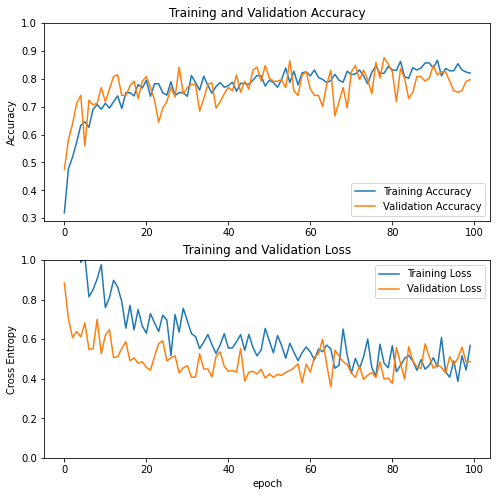

12/12 [==============================] - 0s 35ms/step - loss: 0.3981 - accuracy: 0.8757
Test accuracy : 0.8757061958312988
12/12 [==============================] - 1s 29ms/step
Confusion matrix, without normalization
[[104   1   6   7]
 [  0  17   0   4]
 [  0   1  19   0]
 [  0   2   1  15]]
Normalized confusion matrix
[[0.88135593 0.00847458 0.05084746 0.05932203]
 [0.         0.80952381 0.         0.19047619]
 [0.         0.05       0.95       0.        ]
 [0.         0.11111111 0.05555556 0.83333333]]

Accuracy: 0.8757


Balanced Accuracy: 0.8686

Macro Precision: 0.7793
Macro Recall: 0.8686
Macro F1-score: 0.8136

Kappa score: 0.7791

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.88      0.94       118
     Grade_1       0.81      0.81      0.81        21
     Grade_2       0.73      0.95      0.83        20
     Grade_3       0.58      0.83      0.68        18

    accuracy                           0.88       177
   

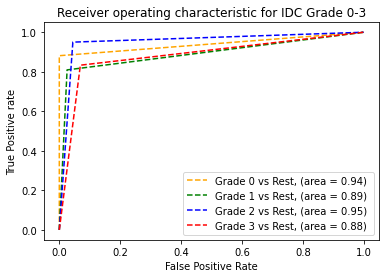

Selected model: EB0V2 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_22 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_22 (KerasLayer)  (None, 1280)             5919312   
                                                                 
 dropout_44 (Dropout)        (None, 1280)              0         
                                                                 
 dense_44 (Dense)            (None, 256)               327

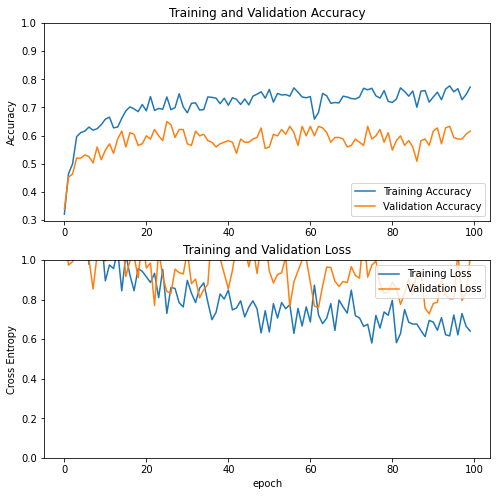

12/12 [==============================] - 0s 33ms/step - loss: 0.8416 - accuracy: 0.6497
Test accuracy : 0.6497175097465515
12/12 [==============================] - 1s 24ms/step
Confusion matrix, without normalization
[[68  9  1 40]
 [ 3 14  1  3]
 [ 3  0 15  2]
 [ 0  0  0 18]]
Normalized confusion matrix
[[0.57627119 0.07627119 0.00847458 0.33898305]
 [0.14285714 0.66666667 0.04761905 0.14285714]
 [0.15       0.         0.75       0.1       ]
 [0.         0.         0.         1.        ]]

Accuracy: 0.6497


Balanced Accuracy: 0.7482

Macro Precision: 0.6739
Macro Recall: 0.7482
Macro F1-score: 0.6500

Kappa score: 0.4683

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.92      0.58      0.71       118
     Grade_1       0.61      0.67      0.64        21
     Grade_2       0.88      0.75      0.81        20
     Grade_3       0.29      1.00      0.44        18

    accuracy                           0.65       177
   macro avg       

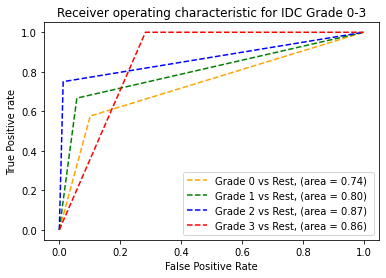

Selected model: EB0V2-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2-21k"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_23 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_23 (KerasLayer)  (None, 1280)             5919312   
                                                                 
 dropout_46 (Dropout)        (None, 1280)              0         
                                                                 
 dense_46 (Dense)            (None, 256)        

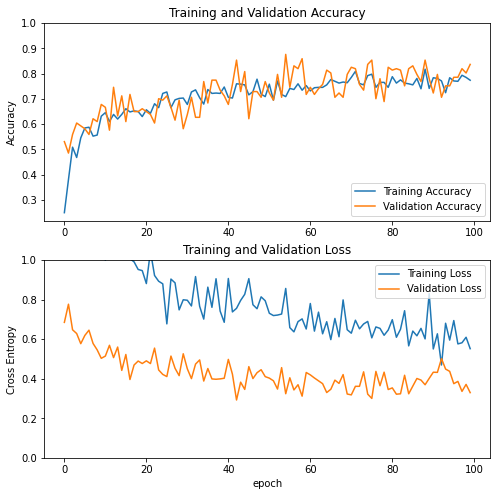

12/12 [==============================] - 0s 33ms/step - loss: 0.3241 - accuracy: 0.8757
Test accuracy : 0.8757061958312988
12/12 [==============================] - 1s 24ms/step
Confusion matrix, without normalization
[[101   8   3   6]
 [  0  17   1   3]
 [  0   0  20   0]
 [  0   1   0  17]]
Normalized confusion matrix
[[0.8559322  0.06779661 0.02542373 0.05084746]
 [0.         0.80952381 0.04761905 0.14285714]
 [0.         0.         1.         0.        ]
 [0.         0.05555556 0.         0.94444444]]

Accuracy: 0.8757


Balanced Accuracy: 0.9025

Macro Precision: 0.7853
Macro Recall: 0.9025
Macro F1-score: 0.8319

Kappa score: 0.7827

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.86      0.92       118
     Grade_1       0.65      0.81      0.72        21
     Grade_2       0.83      1.00      0.91        20
     Grade_3       0.65      0.94      0.77        18

    accuracy                           0.88       177
   

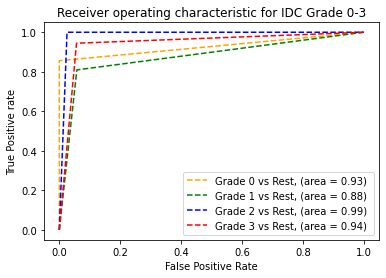

Selected model: RV1 : https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_24 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_24 (KerasLayer)  (None, 2048)             23561152  
                                                                 
 dropout_48 (Dropout)        (None, 2048)              0         
                                                                 
 dense_48 (Dense)            (None, 256)               524544    
                              

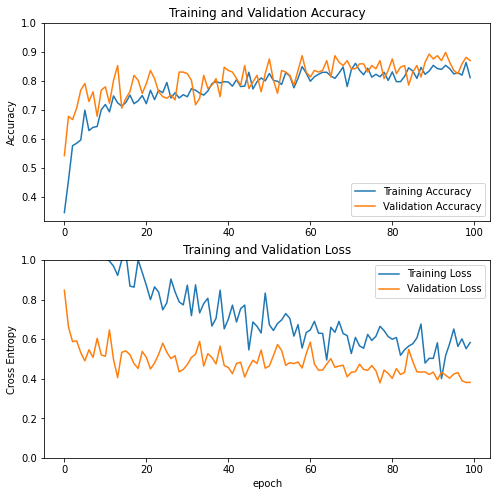

12/12 [==============================] - 1s 44ms/step - loss: 0.4182 - accuracy: 0.8983
Test accuracy : 0.8983050584793091
12/12 [==============================] - 1s 39ms/step
Confusion matrix, without normalization
[[110   0   2   6]
 [  1  16   0   4]
 [  0   3  17   0]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.93220339 0.         0.01694915 0.05084746]
 [0.04761905 0.76190476 0.         0.19047619]
 [0.         0.15       0.85       0.        ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.8983


Balanced Accuracy: 0.8582

Macro Precision: 0.8141
Macro Recall: 0.8582
Macro F1-score: 0.8296

Kappa score: 0.8120

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.99      0.93      0.96       118
     Grade_1       0.80      0.76      0.78        21
     Grade_2       0.85      0.85      0.85        20
     Grade_3       0.62      0.89      0.73        18

    accuracy                           0.90       177
   

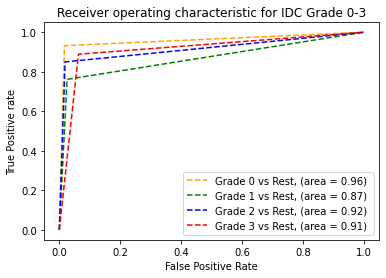

Selected model: RV2 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_25 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_25 (KerasLayer)  (None, 2048)             23564800  
                                                                 
 dropout_50 (Dropout)        (None, 2048)              0         
                                                                 
 dense_50 (Dense)            (None, 256)               524544    
                              

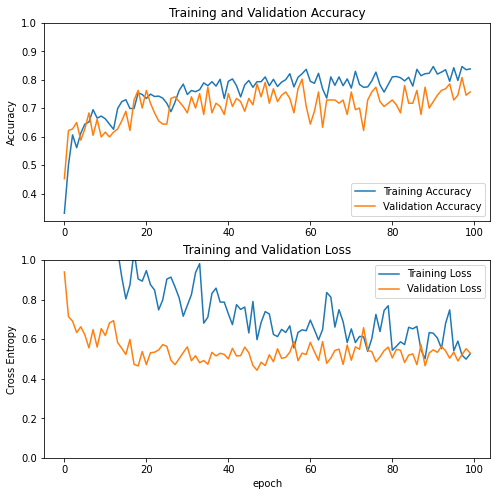

12/12 [==============================] - 1s 48ms/step - loss: 0.5216 - accuracy: 0.8079
Test accuracy : 0.8079096078872681
12/12 [==============================] - 1s 44ms/step
Confusion matrix, without normalization
[[97 11  1  9]
 [ 1 16  1  3]
 [ 0  3 16  1]
 [ 0  3  1 14]]
Normalized confusion matrix
[[0.8220339  0.09322034 0.00847458 0.07627119]
 [0.04761905 0.76190476 0.04761905 0.14285714]
 [0.         0.15       0.8        0.05      ]
 [0.         0.16666667 0.05555556 0.77777778]]

Accuracy: 0.8079


Balanced Accuracy: 0.7904

Macro Precision: 0.7088
Macro Recall: 0.7904
Macro F1-score: 0.7334

Kappa score: 0.6694

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.99      0.82      0.90       118
     Grade_1       0.48      0.76      0.59        21
     Grade_2       0.84      0.80      0.82        20
     Grade_3       0.52      0.78      0.62        18

    accuracy                           0.81       177
   macro avg       

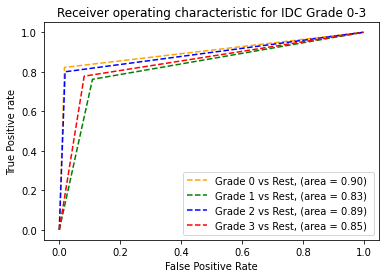

Selected model: MB1 : https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_26 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_26 (KerasLayer)  (None, 1024)             3228864   
                                                                 
 dropout_52 (Dropout)        (None, 1024)              0         
                                                                 
 dense_52 (Dense)            (None, 256)               262400    
              

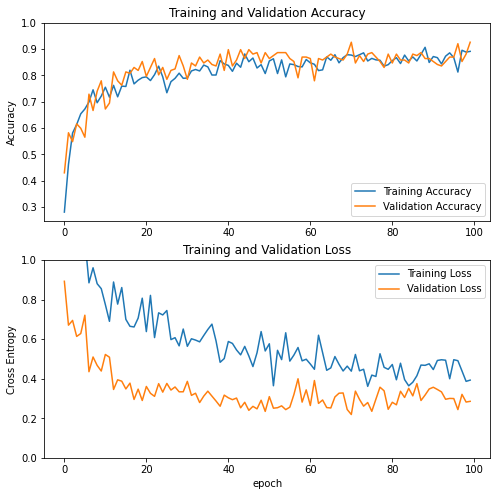

12/12 [==============================] - 0s 21ms/step - loss: 0.2191 - accuracy: 0.9266
Test accuracy : 0.9265536665916443
12/12 [==============================] - 0s 18ms/step
Confusion matrix, without normalization
[[112   0   2   4]
 [  1  15   2   3]
 [  0   0  20   0]
 [  0   1   0  17]]
Normalized confusion matrix
[[0.94915254 0.         0.01694915 0.03389831]
 [0.04761905 0.71428571 0.0952381  0.14285714]
 [0.         0.         1.         0.        ]
 [0.         0.05555556 0.         0.94444444]]

Accuracy: 0.9266


Balanced Accuracy: 0.9020

Macro Precision: 0.8676
Macro Recall: 0.9020
Macro F1-score: 0.8748

Kappa score: 0.8626

Classification Report

              precision    recall  f1-score   support

    Grade_0        0.99      0.95      0.97       118
     Grade_1       0.94      0.71      0.81        21
     Grade_2       0.83      1.00      0.91        20
     Grade_3       0.71      0.94      0.81        18

    accuracy                           0.93       177
   

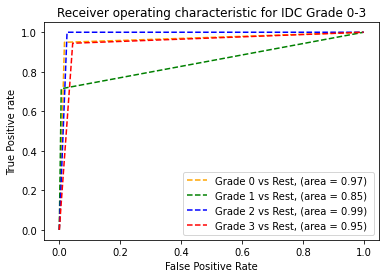

Selected model: MB2 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_27 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_27 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dropout_54 (Dropout)        (None, 1280)              0         
                                                                 
 dense_54 (Dense)            (None, 256)               327936    
              

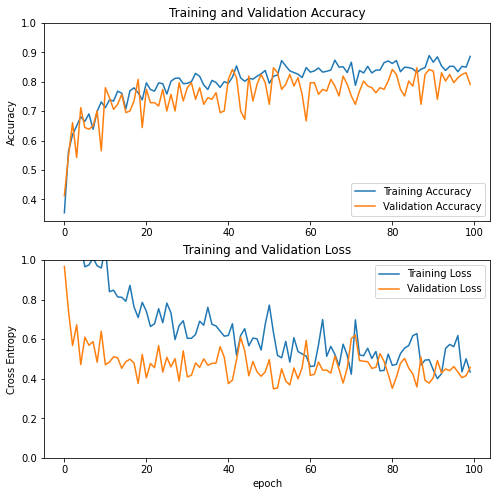

12/12 [==============================] - 0s 27ms/step - loss: 0.3487 - accuracy: 0.8475
Test accuracy : 0.8474576473236084
12/12 [==============================] - 1s 19ms/step
Confusion matrix, without normalization
[[100   6   3   9]
 [  0  17   1   3]
 [  0   4  16   0]
 [  0   1   0  17]]
Normalized confusion matrix
[[0.84745763 0.05084746 0.02542373 0.07627119]
 [0.         0.80952381 0.04761905 0.14285714]
 [0.         0.2        0.8        0.        ]
 [0.         0.05555556 0.         0.94444444]]

Accuracy: 0.8475


Balanced Accuracy: 0.8504

Macro Precision: 0.7483
Macro Recall: 0.8504
Macro F1-score: 0.7837

Kappa score: 0.7348

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.85      0.92       118
     Grade_1       0.61      0.81      0.69        21
     Grade_2       0.80      0.80      0.80        20
     Grade_3       0.59      0.94      0.72        18

    accuracy                           0.85       177
   

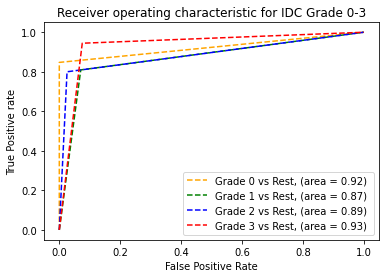

In [ ]:
model_list = ['EB0', 'EB0V2', 'EB0V2-21k', 'RV1', 'RV2', 'MB1', 'MB2']
train_dir =f'/content/{sn_label}_{temp_img}/Training Set'
test_dir =f'/content/{sn_label}_{temp_img}/Test Set'


train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size= IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode = 'categorical')

class_names = train_ds.class_names
print(class_names)

normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

y = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = generate_class_weights(y, multi_class=True, one_hot_encoded=True)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


for model_name in model_list:
  model = create_model(model_name, class_weights)


  best_weight_path = f'{best_weight_dir}/{model_name}_best.h5'
  cp_callback = tf.keras.callbacks.ModelCheckpoint(best_weight_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 


  history=model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=EPOCHS,
  callbacks = [cp_callback], 
  class_weight = class_weights
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_Train_Val_Curve.png')
  plt.show()
  plt.close()

  model.load_weights(best_weight_path)

  loss, accuracy = model.evaluate(test_ds)
  print('Test accuracy :', accuracy)

  test_labels = np.concatenate([y for x, y in test_ds], axis=0)
  predictions = model.predict(test_ds)
  y_pred = np.argmax(predictions, axis=1)
  y_label = np.argmax(test_labels, axis=1)

  cm = confusion_matrix(y_label, y_pred)
  plot_confusion_matrix(cm, classes= class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM.png' )
  plot_confusion_matrix(cm, normalize = True, classes = class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM_Norm.png')


  print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
  print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

  print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
  print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
  print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
  print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

  print('\nClassification Report\n')
  print(classification_report(y_label, y_pred, target_names=class_names))

  baccuracy = round(balanced_accuracy_score(y_label, y_pred), 4)
  macro_precision = round(precision_score(y_label, y_pred, average='macro'), 4)
  macro_recall = round(recall_score(y_label, y_pred, average='macro'), 4)
  macro_f1score = round(f1_score(y_label, y_pred, average='macro'), 4)
  kappa_score = round(cohen_kappa_score(y_label, y_pred), 4)

  y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
  y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

  # Plot ROC Curve
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = 4
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])


  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
  plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
  plt.title('Receiver operating characteristic for IDC Grade 0-3')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_ROC.png')
  plt.show()
  plt.close()



  df = pd.DataFrame({'Model Name': model_name, 'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score}, index=[0])  

  df.to_csv(result_dir,  mode='a', index=False, header=False) 


# Temp 5

# Setup SN Dataset

In [ ]:
# Reinhard
sn_label = 'V'
temp_img = 'Temp5'

# original dataset
base_path = "/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset"

# temp image path
temp_img_path = f"/content/drive/Shareddrives/Unlimited Drive/SN/Template/{temp_img}.png"

#  make a temp directory to save SN dataset
save_path = f'/content/{sn_label}_{temp_img}'
if not os.path.exists(save_path):
  os.mkdir(save_path)

# Setup Model

In [ ]:
# Set hyperparameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100
print('Batch size:', BATCH_SIZE, 'Epoch: ', EPOCHS)

best_weight_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Weight/{sn_label}_{temp_img}'
if not os.path.exists(best_weight_dir):
   os.mkdir(best_weight_dir)

   
figure_dir = '/content/drive/Shareddrives/Unlimited Drive/SN/Result/Figures'




metrics = {'Model Name': [], 'Balanced Accuracy': [], 'Macro Precision': [], 'Macro Recall': [], 'Macro F1score': [], 'Kappa Score': []}
result_dir = f'/content/drive/Shareddrives/Unlimited Drive/SN/Result/{sn_label}_{temp_img}_result.csv'
if not os.path.exists(result_dir):
  df = pd.DataFrame(metrics) 
  df.to_csv(result_dir, index=False) 

Batch size: 16 Epoch:  100


# Form SN datasets

In [ ]:
# Define normalizer
normalizer = staintools.StainNormalizer(method="vahadane")

# Read template image
print(temp_img_path)
normalizer.fit(staintools.read_image(temp_img_path))

print(f'Folder contains {len(os.listdir(base_path))} folders')
print(os.listdir(base_path))

print('')

for type_folder in os.listdir(base_path):
  type_path = os.path.join(base_path, type_folder)
  print(f'In Folder :{type_path}')
  print('')

  for grade_folder in os.listdir(type_path):
    grade_path = os.path.join(type_path, grade_folder)
    print(f'In Folder :{grade_path}')
    print('')

    for files in os.listdir(grade_path):
      
      image_path = os.path.join(grade_path, files)
      im = normalizer.transform(staintools.read_image(image_path))


      saveim_path = os.path.join(save_path, type_folder, grade_folder)
      if not os.path.exists(saveim_path):
        os.makedirs(saveim_path)

        
      os.chdir(saveim_path) 
      file_name = str(files)
      cv.imwrite(file_name,im)

 

/content/drive/Shareddrives/Unlimited Drive/SN/Template/Temp5.png
Folder contains 2 folders
['Training Set', 'Test Set']

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_3

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_0 

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Training Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_2

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_1

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/Test Set/Grade_0

In Folder :/content/drive/Shareddrives/Unlimited Drive/SN/FBCG Dataset/T

# Train and Test Models

Found 711 files belonging to 4 classes.
Found 177 files belonging to 4 classes.
['Grade_0 ', 'Grade_1', 'Grade_2', 'Grade_3']
Selected model: EB0 : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Building model with https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_28 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_28 (KerasLayer)  (None, 1280)             4049564   
                                                                 
 dropout_56 (Dropout)        (None, 1280)              0         
                                        

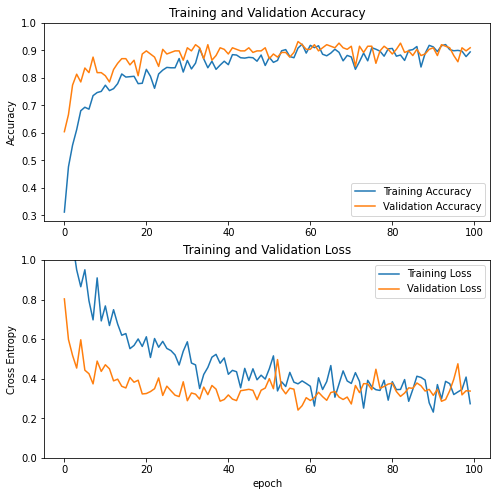

12/12 [==============================] - 0s 34ms/step - loss: 0.2414 - accuracy: 0.9322
Test accuracy : 0.9322034120559692
12/12 [==============================] - 1s 28ms/step
Confusion matrix, without normalization
[[113   3   2   0]
 [  0  18   0   3]
 [  0   3  17   0]
 [  0   1   0  17]]
Normalized confusion matrix
[[0.95762712 0.02542373 0.01694915 0.        ]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.15       0.85       0.        ]
 [0.         0.05555556 0.         0.94444444]]

Accuracy: 0.9322


Balanced Accuracy: 0.9023

Macro Precision: 0.8662
Macro Recall: 0.9023
Macro F1-score: 0.8819

Kappa score: 0.8730

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.96      0.98       118
     Grade_1       0.72      0.86      0.78        21
     Grade_2       0.89      0.85      0.87        20
     Grade_3       0.85      0.94      0.89        18

    accuracy                           0.93       177
   

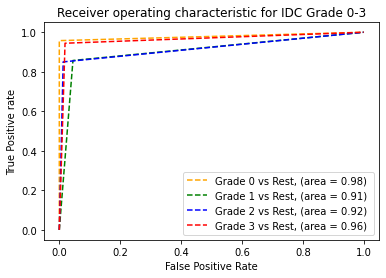

Selected model: EB0V2 : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_29 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_29 (KerasLayer)  (None, 1280)             5919312   
                                                                 
 dropout_58 (Dropout)        (None, 1280)              0         
                                                                 
 dense_58 (Dense)            (None, 256)               327

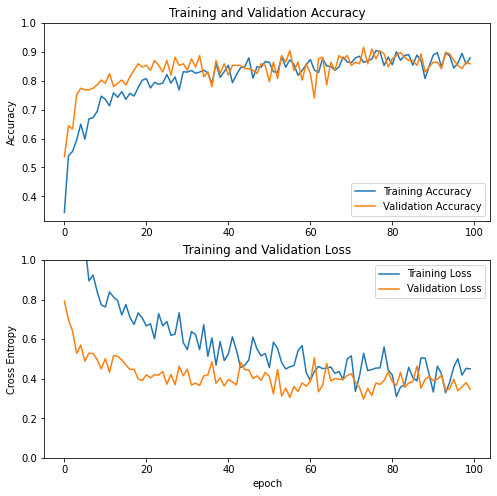

12/12 [==============================] - 0s 33ms/step - loss: 0.2968 - accuracy: 0.9153
Test accuracy : 0.9152542352676392
12/12 [==============================] - 1s 24ms/step
Confusion matrix, without normalization
[[112   4   2   0]
 [  0  19   0   2]
 [  0   5  15   0]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.94915254 0.03389831 0.01694915 0.        ]
 [0.         0.9047619  0.         0.0952381 ]
 [0.         0.25       0.75       0.        ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.9153


Balanced Accuracy: 0.8732

Macro Precision: 0.8443
Macro Recall: 0.8732
Macro F1-score: 0.8531

Kappa score: 0.8422

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.95      0.97       118
     Grade_1       0.66      0.90      0.76        21
     Grade_2       0.83      0.75      0.79        20
     Grade_3       0.89      0.89      0.89        18

    accuracy                           0.92       177
   

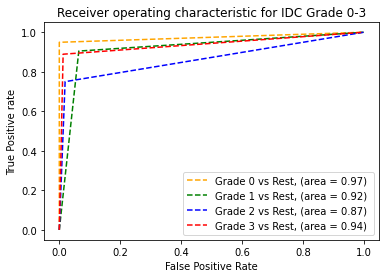

Selected model: EB0V2-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "EB0V2-21k"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_30 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_30 (KerasLayer)  (None, 1280)             5919312   
                                                                 
 dropout_60 (Dropout)        (None, 1280)              0         
                                                                 
 dense_60 (Dense)            (None, 256)        

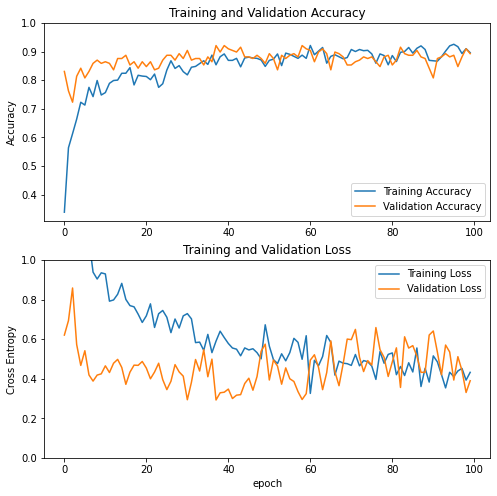

12/12 [==============================] - 0s 32ms/step - loss: 0.2925 - accuracy: 0.9209
Test accuracy : 0.9209039807319641
12/12 [==============================] - 1s 24ms/step
Confusion matrix, without normalization
[[114   2   1   1]
 [  0  18   0   3]
 [  0   6  14   0]
 [  0   1   0  17]]
Normalized confusion matrix
[[0.96610169 0.01694915 0.00847458 0.00847458]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.3        0.7        0.        ]
 [0.         0.05555556 0.         0.94444444]]

Accuracy: 0.9209


Balanced Accuracy: 0.8669

Macro Precision: 0.8524
Macro Recall: 0.8669
Macro F1-score: 0.8511

Kappa score: 0.8510

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.97      0.98       118
     Grade_1       0.67      0.86      0.75        21
     Grade_2       0.93      0.70      0.80        20
     Grade_3       0.81      0.94      0.87        18

    accuracy                           0.92       177
   

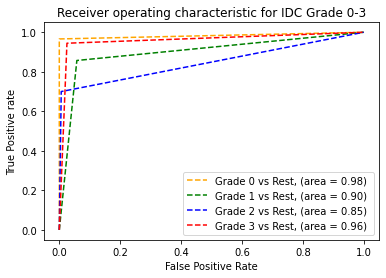

Selected model: RV1 : https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_31 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_31 (KerasLayer)  (None, 2048)             23561152  
                                                                 
 dropout_62 (Dropout)        (None, 2048)              0         
                                                                 
 dense_62 (Dense)            (None, 256)               524544    
                              

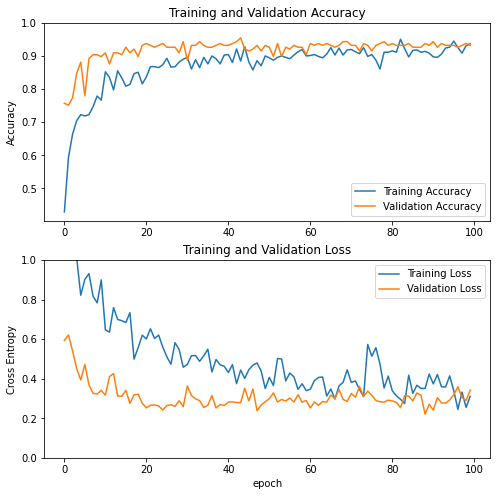

12/12 [==============================] - 1s 47ms/step - loss: 0.2788 - accuracy: 0.9548
Test accuracy : 0.9548022747039795
12/12 [==============================] - 1s 39ms/step
Confusion matrix, without normalization
[[117   0   0   1]
 [  0  18   0   3]
 [  0   2  18   0]
 [  0   1   1  16]]
Normalized confusion matrix
[[0.99152542 0.         0.         0.00847458]
 [0.         0.85714286 0.         0.14285714]
 [0.         0.1        0.9        0.        ]
 [0.         0.05555556 0.05555556 0.88888889]]

Accuracy: 0.9548


Balanced Accuracy: 0.9094

Macro Precision: 0.9011
Macro Recall: 0.9094
Macro F1-score: 0.9045

Kappa score: 0.9134

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.99      1.00       118
     Grade_1       0.86      0.86      0.86        21
     Grade_2       0.95      0.90      0.92        20
     Grade_3       0.80      0.89      0.84        18

    accuracy                           0.95       177
   

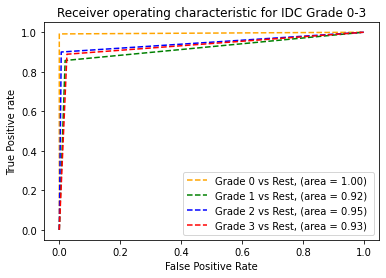

Selected model: RV2 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "RV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_32 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_32 (KerasLayer)  (None, 2048)             23564800  
                                                                 
 dropout_64 (Dropout)        (None, 2048)              0         
                                                                 
 dense_64 (Dense)            (None, 256)               524544    
                              

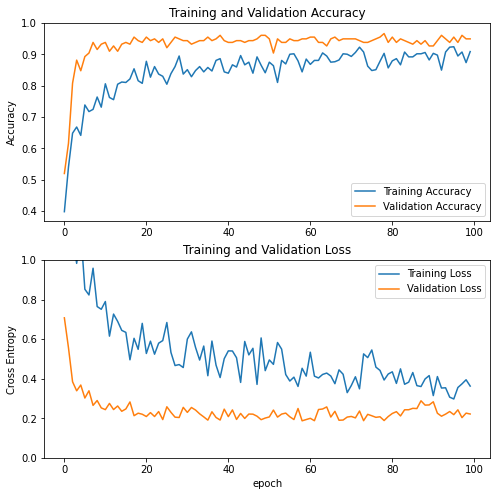

12/12 [==============================] - 1s 49ms/step - loss: 0.1885 - accuracy: 0.9661
Test accuracy : 0.9661017060279846
12/12 [==============================] - 1s 45ms/step
Confusion matrix, without normalization
[[117   0   1   0]
 [  0  19   0   2]
 [  0   2  18   0]
 [  0   0   1  17]]
Normalized confusion matrix
[[0.99152542 0.         0.00847458 0.        ]
 [0.         0.9047619  0.         0.0952381 ]
 [0.         0.1        0.9        0.        ]
 [0.         0.         0.05555556 0.94444444]]

Accuracy: 0.9661


Balanced Accuracy: 0.9352

Macro Precision: 0.9249
Macro Recall: 0.9352
Macro F1-score: 0.9299

Kappa score: 0.9350

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.99      1.00       118
     Grade_1       0.90      0.90      0.90        21
     Grade_2       0.90      0.90      0.90        20
     Grade_3       0.89      0.94      0.92        18

    accuracy                           0.97       177
   

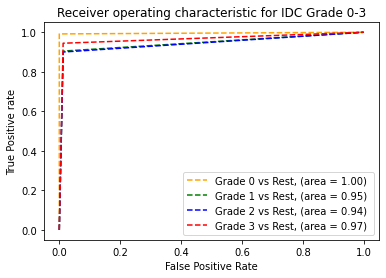

Selected model: MB1 : https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_33 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_33 (KerasLayer)  (None, 1024)             3228864   
                                                                 
 dropout_66 (Dropout)        (None, 1024)              0         
                                                                 
 dense_66 (Dense)            (None, 256)               262400    
              

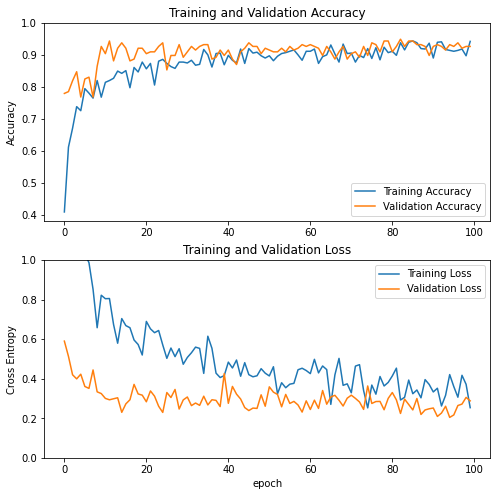

12/12 [==============================] - 0s 22ms/step - loss: 0.2243 - accuracy: 0.9492
Test accuracy : 0.9491525292396545
12/12 [==============================] - 1s 17ms/step
Confusion matrix, without normalization
[[118   0   0   0]
 [  0  16   2   3]
 [  0   4  16   0]
 [  0   0   0  18]]
Normalized confusion matrix
[[1.         0.         0.         0.        ]
 [0.         0.76190476 0.0952381  0.14285714]
 [0.         0.2        0.8        0.        ]
 [0.         0.         0.         1.        ]]

Accuracy: 0.9492


Balanced Accuracy: 0.8905

Macro Precision: 0.8865
Macro Recall: 0.8905
Macro F1-score: 0.8864

Kappa score: 0.9020

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      1.00      1.00       118
     Grade_1       0.80      0.76      0.78        21
     Grade_2       0.89      0.80      0.84        20
     Grade_3       0.86      1.00      0.92        18

    accuracy                           0.95       177
   

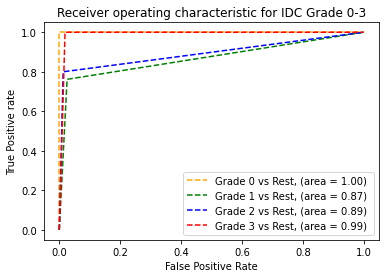

Selected model: MB2 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
Class weights: [0.37819149 2.06686047 2.16768293 2.43493151]
Model: "MB2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_34 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer_34 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dropout_68 (Dropout)        (None, 1280)              0         
                                                                 
 dense_68 (Dense)            (None, 256)               327936    
              

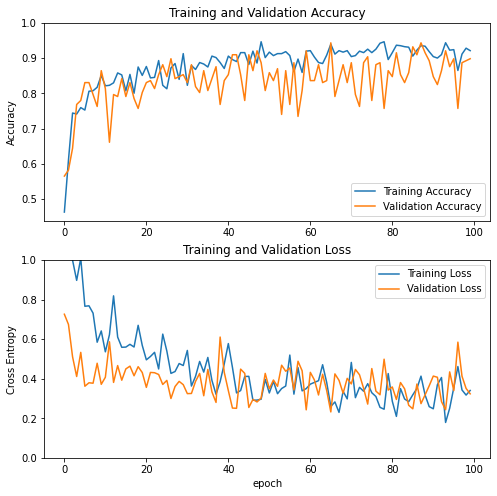

12/12 [==============================] - 0s 25ms/step - loss: 0.2320 - accuracy: 0.9435
Test accuracy : 0.9435028433799744
12/12 [==============================] - 1s 19ms/step
Confusion matrix, without normalization
[[115   3   0   0]
 [  0  19   0   2]
 [  0   3  17   0]
 [  0   2   0  16]]
Normalized confusion matrix
[[0.97457627 0.02542373 0.         0.        ]
 [0.         0.9047619  0.         0.0952381 ]
 [0.         0.15       0.85       0.        ]
 [0.         0.11111111 0.         0.88888889]]

Accuracy: 0.9435


Balanced Accuracy: 0.9046

Macro Precision: 0.8981
Macro Recall: 0.9046
Macro F1-score: 0.8966

Kappa score: 0.8929

Classification Report

              precision    recall  f1-score   support

    Grade_0        1.00      0.97      0.99       118
     Grade_1       0.70      0.90      0.79        21
     Grade_2       1.00      0.85      0.92        20
     Grade_3       0.89      0.89      0.89        18

    accuracy                           0.94       177
   

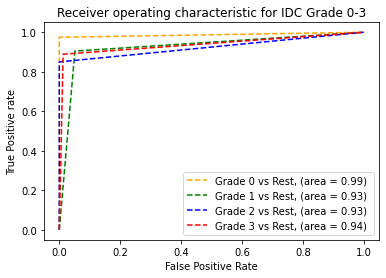

In [ ]:
model_list = ['EB0', 'EB0V2', 'EB0V2-21k', 'RV1', 'RV2', 'MB1', 'MB2']
train_dir =f'/content/{sn_label}_{temp_img}/Training Set'
test_dir =f'/content/{sn_label}_{temp_img}/Test Set'


train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size= IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode = 'categorical')

class_names = train_ds.class_names
print(class_names)

normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

y = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = generate_class_weights(y, multi_class=True, one_hot_encoded=True)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


for model_name in model_list:
  model = create_model(model_name, class_weights)


  best_weight_path = f'{best_weight_dir}/{model_name}_best.h5'
  cp_callback = tf.keras.callbacks.ModelCheckpoint(best_weight_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 


  history=model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=EPOCHS,
  callbacks = [cp_callback], 
  class_weight = class_weights
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_Train_Val_Curve.png')
  plt.show()
  plt.close()

  model.load_weights(best_weight_path)

  loss, accuracy = model.evaluate(test_ds)
  print('Test accuracy :', accuracy)

  test_labels = np.concatenate([y for x, y in test_ds], axis=0)
  predictions = model.predict(test_ds)
  y_pred = np.argmax(predictions, axis=1)
  y_label = np.argmax(test_labels, axis=1)

  cm = confusion_matrix(y_label, y_pred)
  plot_confusion_matrix(cm, classes= class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM.png' )
  plot_confusion_matrix(cm, normalize = True, classes = class_names, dir = f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_CM_Norm.png')


  print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
  print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

  print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
  print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
  print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
  print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

  print('\nClassification Report\n')
  print(classification_report(y_label, y_pred, target_names=class_names))

  baccuracy = round(balanced_accuracy_score(y_label, y_pred), 4)
  macro_precision = round(precision_score(y_label, y_pred, average='macro'), 4)
  macro_recall = round(recall_score(y_label, y_pred, average='macro'), 4)
  macro_f1score = round(f1_score(y_label, y_pred, average='macro'), 4)
  kappa_score = round(cohen_kappa_score(y_label, y_pred), 4)

  y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
  y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

  # Plot ROC Curve
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = 4
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])


  plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
  plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
  plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
  plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
  plt.title('Receiver operating characteristic for IDC Grade 0-3')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.savefig(f'{figure_dir}/{sn_label}_{temp_img}_{model_name}_ROC.png')
  plt.show()
  plt.close()



  df = pd.DataFrame({'Model Name': model_name, 'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score}, index=[0])  

  df.to_csv(result_dir,  mode='a', index=False, header=False) 
